In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
best_eer


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100)) 

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_equal_error_rate'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='min', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='min', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=100, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 17s 4ms/step - loss: 0.5658 - accuracy: 0.6579 - precision: 0.9375 - recall: 0.6398 - f1: 0.7546 - specificity: 0.7791 - negative_predictive_value: 0.2976 - matthews_correlation_coefficient: 0.3128 - equal_error_rate: 0.2731 - val_loss: 0.5605 - val_accuracy: 0.6444 - val_precision: 0.9735 - val_recall: 0.5951 - val_f1: 0.7380 - val_specificity: 0.8992 - val_negative_predictive_value: 0.2885 - val_matthews_correlation_coefficient: 0.3585 - val_equal_error_rate: 0.2578

Epoch 00001: val_equal_error_rate improved from inf to 0.25783, saving model to ../models/autoencoders_requirements/blurred_2020_04_09-00_13_47.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4890 - accuracy: 0.6807 - precision: 0.9591 - recall: 0.6514 - f1: 0.7737 - specificity: 0.8484 - negative_predictive_value: 0.3173 - matthews_correlation_coefficient: 0.3696 - equal_error_rate:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4428 - accuracy: 0.7325 - precision: 0.9559 - recall: 0.7163 - f1: 0.8149 - specificity: 0.8389 - negative_predictive_value: 0.3665 - matthews_correlation_coefficient: 0.4203 - equal_error_rate: 0.2035 - val_loss: 0.4912 - val_accuracy: 0.6982 - val_precision: 0.9806 - val_recall: 0.6549 - val_f1: 0.7849 - val_specificity: 0.9323 - val_negative_predictive_value: 0.3290 - val_matthews_correlation_coefficient: 0.4246 - val_equal_error_rate: 0.2331

Epoch 00014: val_equal_error_rate did not improve from 0.21564
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4556 - accuracy: 0.6911 - precision: 0.9712 - recall: 0.6564 - f1: 0.7761 - specificity: 0.8540 - negative_predictive_value: 0.3241 - matthews_correlation_coefficient: 0.3894 - equal_error_rate: 0.2016 - val_loss: 0.4444 - val_accuracy: 0.7424 - val_precision: 0.9511 - val_recall: 0.7344 - val_f1: 0.8285 - val_specificity: 0.7925 - val


Epoch 00027: val_equal_error_rate did not improve from 0.21044
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4352 - accuracy: 0.7252 - precision: 0.9708 - recall: 0.6977 - f1: 0.8076 - specificity: 0.8740 - negative_predictive_value: 0.3621 - matthews_correlation_coefficient: 0.4340 - equal_error_rate: 0.2027 - val_loss: 0.4860 - val_accuracy: 0.7285 - val_precision: 0.9587 - val_recall: 0.7101 - val_f1: 0.8154 - val_specificity: 0.8290 - val_negative_predictive_value: 0.3416 - val_matthews_correlation_coefficient: 0.4012 - val_equal_error_rate: 0.2212

Epoch 00028: val_equal_error_rate did not improve from 0.21044
Epoch 29/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4238 - accuracy: 0.7490 - precision: 0.9669 - recall: 0.7320 - f1: 0.8308 - specificity: 0.8592 - negative_predictive_value: 0.3751 - matthews_correlation_coefficient: 0.4480 - equal_error_rate: 0.1963 - val_loss: 0.4224 - val_accuracy: 0.7606 - val_precision:


Epoch 00041: val_equal_error_rate did not improve from 0.20621
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3939 - accuracy: 0.7701 - precision: 0.9731 - recall: 0.7484 - f1: 0.8451 - specificity: 0.8859 - negative_predictive_value: 0.3991 - matthews_correlation_coefficient: 0.4845 - equal_error_rate: 0.1794 - val_loss: 0.3877 - val_accuracy: 0.7806 - val_precision: 0.9425 - val_recall: 0.7894 - val_f1: 0.8587 - val_specificity: 0.7283 - val_negative_predictive_value: 0.3854 - val_matthews_correlation_coefficient: 0.4112 - val_equal_error_rate: 0.2007

Epoch 00042: val_equal_error_rate improved from 0.20621 to 0.20067, saving model to ../models/autoencoders_requirements/blurred_2020_04_09-00_13_47.h5
Epoch 43/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4010 - accuracy: 0.7675 - precision: 0.9712 - recall: 0.7460 - f1: 0.8413 - specificity: 0.8821 - negative_predictive_value: 0.4006 - matthews_correlation_coefficient: 0.48

4610/4610 [==============================] - 12s 3ms/step - loss: 0.3907 - accuracy: 0.7783 - precision: 0.9683 - recall: 0.7634 - f1: 0.8511 - specificity: 0.8725 - negative_predictive_value: 0.4192 - matthews_correlation_coefficient: 0.4941 - equal_error_rate: 0.1684 - val_loss: 0.4249 - val_accuracy: 0.7875 - val_precision: 0.9430 - val_recall: 0.7977 - val_f1: 0.8636 - val_specificity: 0.7203 - val_negative_predictive_value: 0.3963 - val_matthews_correlation_coefficient: 0.4186 - val_equal_error_rate: 0.2131

Epoch 00055: val_equal_error_rate did not improve from 0.19447
Epoch 56/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3849 - accuracy: 0.7709 - precision: 0.9736 - recall: 0.7494 - f1: 0.8455 - specificity: 0.8745 - negative_predictive_value: 0.3933 - matthews_correlation_coefficient: 0.4780 - equal_error_rate: 0.1591 - val_loss: 0.3389 - val_accuracy: 0.8222 - val_precision: 0.9337 - val_recall: 0.8478 - val_f1: 0.8883 - val_specificity: 0.6633 - val


Epoch 00068: val_equal_error_rate did not improve from 0.17891
Epoch 69/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3713 - accuracy: 0.7944 - precision: 0.9742 - recall: 0.7722 - f1: 0.8597 - specificity: 0.8912 - negative_predictive_value: 0.4240 - matthews_correlation_coefficient: 0.5120 - equal_error_rate: 0.1572 - val_loss: 0.3703 - val_accuracy: 0.8031 - val_precision: 0.9379 - val_recall: 0.8216 - val_f1: 0.8752 - val_specificity: 0.6805 - val_negative_predictive_value: 0.4085 - val_matthews_correlation_coefficient: 0.4160 - val_equal_error_rate: 0.2048

Epoch 00069: val_equal_error_rate did not improve from 0.17891
Epoch 70/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3714 - accuracy: 0.7967 - precision: 0.9723 - recall: 0.7807 - f1: 0.8645 - specificity: 0.8544 - negative_predictive_value: 0.4217 - matthews_correlation_coefficient: 0.5006 - equal_error_rate: 0.1578 - val_loss: 0.3857 - val_accuracy: 0.7858 - val_precision:


Epoch 00082: val_equal_error_rate did not improve from 0.17891
Epoch 83/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3597 - accuracy: 0.8043 - precision: 0.9743 - recall: 0.7896 - f1: 0.8714 - specificity: 0.8666 - negative_predictive_value: 0.4334 - matthews_correlation_coefficient: 0.5173 - equal_error_rate: 0.1540 - val_loss: 0.3304 - val_accuracy: 0.8283 - val_precision: 0.9365 - val_recall: 0.8548 - val_f1: 0.8933 - val_specificity: 0.6689 - val_negative_predictive_value: 0.4584 - val_matthews_correlation_coefficient: 0.4538 - val_equal_error_rate: 0.1858

Epoch 00083: val_equal_error_rate did not improve from 0.17891
Epoch 84/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3582 - accuracy: 0.8013 - precision: 0.9761 - recall: 0.7824 - f1: 0.8675 - specificity: 0.8779 - negative_predictive_value: 0.4308 - matthews_correlation_coefficient: 0.5194 - equal_error_rate: 0.1502 - val_loss: 0.3304 - val_accuracy: 0.8239 - val_precision:


Epoch 00096: val_equal_error_rate did not improve from 0.17891
Epoch 97/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3483 - accuracy: 0.8080 - precision: 0.9779 - recall: 0.7926 - f1: 0.8747 - specificity: 0.9089 - negative_predictive_value: 0.4487 - matthews_correlation_coefficient: 0.5454 - equal_error_rate: 0.1484 - val_loss: 0.3375 - val_accuracy: 0.8213 - val_precision: 0.9360 - val_recall: 0.8468 - val_f1: 0.8889 - val_specificity: 0.6673 - val_negative_predictive_value: 0.4406 - val_matthews_correlation_coefficient: 0.4396 - val_equal_error_rate: 0.1982

Epoch 00097: val_equal_error_rate did not improve from 0.17891
Epoch 98/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3475 - accuracy: 0.8065 - precision: 0.9776 - recall: 0.7908 - f1: 0.8734 - specificity: 0.9047 - negative_predictive_value: 0.4498 - matthews_correlation_coefficient: 0.5427 - equal_error_rate: 0.1517 - val_loss: 0.3339 - val_accuracy: 0.8378 - val_precision:

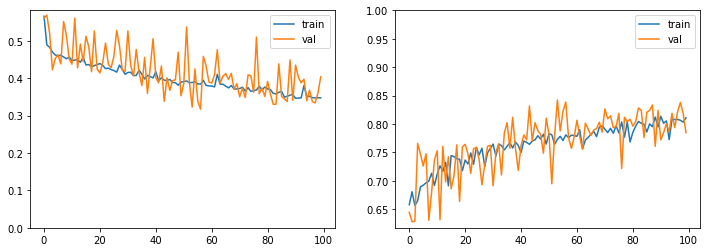

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks]).astype(np.int32)

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6664 - accuracy: 0.6137 - precision: 0.7682 - recall: 0.6052 - f1: 0.6660 - specificity: 0.6102 - negative_predictive_value: 0.4291 - matthews_correlation_coefficient: 0.2057 - equal_error_rate: 0.3887 - val_loss: 0.7685 - val_accuracy: 0.3903 - val_precision: 0.8477 - val_recall: 0.1349 - val_f1: 0.2316 - val_specificity: 0.9468 - val_negative_predictive_value: 0.3348 - val_matthews_correlation_coefficient: 0.1212 - val_equal_error_rate: 0.3193

Epoch 00001: val_equal_error_rate improved from inf to 0.31930, saving model to ../models/autoencoders_requirements/looking_away_2020_04_09-00_34_29.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6601 - accuracy: 0.6056 - precision: 0.7802 - recall: 0.5982 - f1: 0.6499 - specificity: 0.6260 - negative_predictive_value: 0.4374 - matthews_correlation_coefficient: 0.2191 - equal_error_

4610/4610 [==============================] - 13s 3ms/step - loss: 0.6197 - accuracy: 0.6631 - precision: 0.8163 - recall: 0.6554 - f1: 0.7191 - specificity: 0.6751 - negative_predictive_value: 0.4794 - matthews_correlation_coefficient: 0.3122 - equal_error_rate: 0.3239 - val_loss: 0.6661 - val_accuracy: 0.5984 - val_precision: 0.8706 - val_recall: 0.4882 - val_f1: 0.6243 - val_specificity: 0.8458 - val_negative_predictive_value: 0.4308 - val_matthews_correlation_coefficient: 0.3169 - val_equal_error_rate: 0.3033

Epoch 00014: val_equal_error_rate improved from 0.30390 to 0.30335, saving model to ../models/autoencoders_requirements/looking_away_2020_04_09-00_34_29.h5
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6276 - accuracy: 0.6469 - precision: 0.8176 - recall: 0.6306 - f1: 0.7001 - specificity: 0.6802 - negative_predictive_value: 0.4691 - matthews_correlation_coefficient: 0.2980 - equal_error_rate: 0.3310 - val_loss: 0.6190 - val_accuracy: 0.6635 

4610/4610 [==============================] - 13s 3ms/step - loss: 0.5847 - accuracy: 0.6785 - precision: 0.8390 - recall: 0.6540 - f1: 0.7309 - specificity: 0.7170 - negative_predictive_value: 0.4888 - matthews_correlation_coefficient: 0.3484 - equal_error_rate: 0.3147 - val_loss: 0.5885 - val_accuracy: 0.6808 - val_precision: 0.8411 - val_recall: 0.6554 - val_f1: 0.7355 - val_specificity: 0.7339 - val_negative_predictive_value: 0.4946 - val_matthews_correlation_coefficient: 0.3612 - val_equal_error_rate: 0.2982

Epoch 00027: val_equal_error_rate did not improve from 0.28789
Epoch 28/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5807 - accuracy: 0.6857 - precision: 0.8412 - recall: 0.6693 - f1: 0.7404 - specificity: 0.7202 - negative_predictive_value: 0.5003 - matthews_correlation_coefficient: 0.3643 - equal_error_rate: 0.2978 - val_loss: 0.5764 - val_accuracy: 0.6904 - val_precision: 0.8290 - val_recall: 0.6889 - val_f1: 0.7518 - val_specificity: 0.6969 - val


Epoch 00040: val_equal_error_rate did not improve from 0.27415
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5684 - accuracy: 0.6965 - precision: 0.8468 - recall: 0.6777 - f1: 0.7446 - specificity: 0.7049 - negative_predictive_value: 0.5105 - matthews_correlation_coefficient: 0.3775 - equal_error_rate: 0.2871 - val_loss: 0.5877 - val_accuracy: 0.6470 - val_precision: 0.8406 - val_recall: 0.5991 - val_f1: 0.6988 - val_specificity: 0.7572 - val_negative_predictive_value: 0.4632 - val_matthews_correlation_coefficient: 0.3288 - val_equal_error_rate: 0.3078

Epoch 00041: val_equal_error_rate did not improve from 0.27415
Epoch 42/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5672 - accuracy: 0.6970 - precision: 0.8481 - recall: 0.6898 - f1: 0.7575 - specificity: 0.7283 - negative_predictive_value: 0.5260 - matthews_correlation_coefficient: 0.3952 - equal_error_rate: 0.2937 - val_loss: 0.5577 - val_accuracy: 0.6973 - val_precision:


Epoch 00054: val_equal_error_rate did not improve from 0.27415
Epoch 55/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5511 - accuracy: 0.7074 - precision: 0.8571 - recall: 0.6907 - f1: 0.7609 - specificity: 0.7520 - negative_predictive_value: 0.5355 - matthews_correlation_coefficient: 0.4166 - equal_error_rate: 0.2699 - val_loss: 0.6474 - val_accuracy: 0.6236 - val_precision: 0.8748 - val_recall: 0.5260 - val_f1: 0.6558 - val_specificity: 0.8423 - val_negative_predictive_value: 0.4499 - val_matthews_correlation_coefficient: 0.3455 - val_equal_error_rate: 0.2999

Epoch 00055: val_equal_error_rate did not improve from 0.27415
Epoch 56/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5433 - accuracy: 0.7154 - precision: 0.8474 - recall: 0.7165 - f1: 0.7736 - specificity: 0.7180 - negative_predictive_value: 0.5442 - matthews_correlation_coefficient: 0.4121 - equal_error_rate: 0.2782 - val_loss: 0.5734 - val_accuracy: 0.6964 - val_precision:


Epoch 00068: val_equal_error_rate did not improve from 0.27281
Epoch 69/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5353 - accuracy: 0.7239 - precision: 0.8568 - recall: 0.7160 - f1: 0.7758 - specificity: 0.7315 - negative_predictive_value: 0.5481 - matthews_correlation_coefficient: 0.4252 - equal_error_rate: 0.2705 - val_loss: 0.5551 - val_accuracy: 0.6938 - val_precision: 0.8345 - val_recall: 0.6880 - val_f1: 0.7536 - val_specificity: 0.7125 - val_negative_predictive_value: 0.5128 - val_matthews_correlation_coefficient: 0.3727 - val_equal_error_rate: 0.2974

Epoch 00069: val_equal_error_rate did not improve from 0.27281
Epoch 70/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5401 - accuracy: 0.7106 - precision: 0.8594 - recall: 0.7012 - f1: 0.7646 - specificity: 0.7372 - negative_predictive_value: 0.5348 - matthews_correlation_coefficient: 0.4141 - equal_error_rate: 0.2592 - val_loss: 0.5633 - val_accuracy: 0.6912 - val_precision:

4610/4610 [==============================] - 13s 3ms/step - loss: 0.5279 - accuracy: 0.7328 - precision: 0.8588 - recall: 0.7231 - f1: 0.7811 - specificity: 0.7352 - negative_predictive_value: 0.5593 - matthews_correlation_coefficient: 0.4369 - equal_error_rate: 0.2623 - val_loss: 0.7710 - val_accuracy: 0.5776 - val_precision: 0.8895 - val_recall: 0.4379 - val_f1: 0.5855 - val_specificity: 0.8810 - val_negative_predictive_value: 0.4181 - val_matthews_correlation_coefficient: 0.3126 - val_equal_error_rate: 0.3109

Epoch 00082: val_equal_error_rate did not improve from 0.27085
Epoch 83/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5397 - accuracy: 0.7217 - precision: 0.8703 - recall: 0.7037 - f1: 0.7727 - specificity: 0.7591 - negative_predictive_value: 0.5456 - matthews_correlation_coefficient: 0.4382 - equal_error_rate: 0.2588 - val_loss: 0.5885 - val_accuracy: 0.6600 - val_precision: 0.8670 - val_recall: 0.5906 - val_f1: 0.7012 - val_specificity: 0.8077 - val


Epoch 00095: val_equal_error_rate did not improve from 0.26862
Epoch 96/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5054 - accuracy: 0.7525 - precision: 0.8754 - recall: 0.7416 - f1: 0.8002 - specificity: 0.7707 - negative_predictive_value: 0.5891 - matthews_correlation_coefficient: 0.4874 - equal_error_rate: 0.2407 - val_loss: 0.6002 - val_accuracy: 0.6609 - val_precision: 0.8598 - val_recall: 0.5977 - val_f1: 0.7041 - val_specificity: 0.7957 - val_negative_predictive_value: 0.4768 - val_matthews_correlation_coefficient: 0.3636 - val_equal_error_rate: 0.2909

Epoch 00096: val_equal_error_rate did not improve from 0.26862
Epoch 97/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5067 - accuracy: 0.7488 - precision: 0.8729 - recall: 0.7400 - f1: 0.7990 - specificity: 0.7648 - negative_predictive_value: 0.5773 - matthews_correlation_coefficient: 0.4764 - equal_error_rate: 0.2419 - val_loss: 0.6699 - val_accuracy: 0.6123 - val_precision:

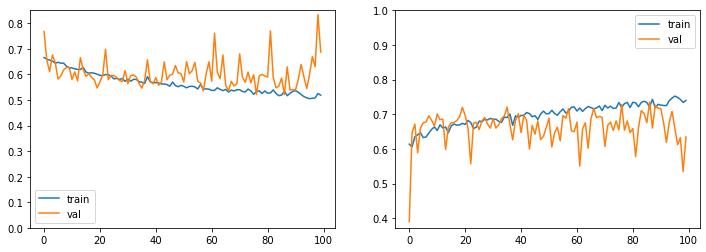

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.7223 - accuracy: 0.5187 - precision: 0.9966 - recall: 0.5278 - f1: 0.6696 - specificity: 0.1489 - negative_predictive_value: 0.0036 - matthews_correlation_coefficient: -3.4438e-04 - equal_error_rate: 0.1026 - val_loss: 0.3868 - val_accuracy: 0.9965 - val_precision: 0.9967 - val_recall: 1.0000 - val_f1: 0.9983 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.0802

Epoch 00001: val_equal_error_rate improved from inf to 0.08025, saving model to ../models/autoencoders_requirements/ink_marked_creased_2020_04_09-00_55_45.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.8067 - accuracy: 0.6111 - precision: 0.8488 - recall: 0.6000 - f1: 0.6251 - specificity: 0.1489 - negative_predictive_value: 0.0016 - matthews_correlation_coefficient


Epoch 00014: val_equal_error_rate did not improve from 0.08025
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6387 - accuracy: 0.7265 - precision: 0.9980 - recall: 0.7227 - f1: 0.8214 - specificity: 0.1489 - negative_predictive_value: 0.0093 - matthews_correlation_coefficient: 0.0176 - equal_error_rate: 0.0595 - val_loss: 0.8866 - val_accuracy: 0.3356 - val_precision: 0.9931 - val_recall: 0.3376 - val_f1: 0.5015 - val_specificity: 0.0833 - val_negative_predictive_value: 0.0013 - val_matthews_correlation_coefficient: -0.0271 - val_equal_error_rate: 0.1102

Epoch 00015: val_equal_error_rate did not improve from 0.08025
Epoch 16/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6849 - accuracy: 0.5471 - precision: 0.9985 - recall: 0.5446 - f1: 0.6910 - specificity: 0.2340 - negative_predictive_value: 0.0093 - matthews_correlation_coefficient: 0.0241 - equal_error_rate: 0.0602 - val_loss: 0.8419 - val_accuracy: 0.2810 - val_precision


Epoch 00028: val_equal_error_rate did not improve from 0.08025
Epoch 29/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.6022 - accuracy: 0.6226 - precision: 0.9979 - recall: 0.6166 - f1: 0.7479 - specificity: 0.1809 - negative_predictive_value: 0.0061 - matthews_correlation_coefficient: 0.0178 - equal_error_rate: 0.0444 - val_loss: 0.6983 - val_accuracy: 0.4076 - val_precision: 0.9943 - val_recall: 0.4122 - val_f1: 0.5804 - val_specificity: 0.0833 - val_negative_predictive_value: 0.0014 - val_matthews_correlation_coefficient: -0.0215 - val_equal_error_rate: 0.1119

Epoch 00029: val_equal_error_rate did not improve from 0.08025
Epoch 30/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.5967 - accuracy: 0.4616 - precision: 0.9982 - recall: 0.4613 - f1: 0.6289 - specificity: 0.2128 - negative_predictive_value: 0.0053 - matthews_correlation_coefficient: 0.0153 - equal_error_rate: 0.0482 - val_loss: 0.6525 - val_accuracy: 0.4545 - val_precision


Epoch 00042: val_equal_error_rate did not improve from 0.08025
Epoch 43/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.4986 - accuracy: 0.6601 - precision: 0.9994 - recall: 0.6581 - f1: 0.7912 - specificity: 0.2660 - negative_predictive_value: 0.0099 - matthews_correlation_coefficient: 0.0377 - equal_error_rate: 0.0259 - val_loss: 0.5802 - val_accuracy: 0.5473 - val_precision: 0.9958 - val_recall: 0.5499 - val_f1: 0.7060 - val_specificity: 0.0833 - val_negative_predictive_value: 0.0019 - val_matthews_correlation_coefficient: -0.0113 - val_equal_error_rate: 0.1506

Epoch 00043: val_equal_error_rate did not improve from 0.08025
Epoch 44/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.5091 - accuracy: 0.6174 - precision: 0.9994 - recall: 0.6200 - f1: 0.7622 - specificity: 0.2553 - negative_predictive_value: 0.0095 - matthews_correlation_coefficient: 0.0351 - equal_error_rate: 0.0247 - val_loss: 0.4373 - val_accuracy: 0.7372 - val_precision

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


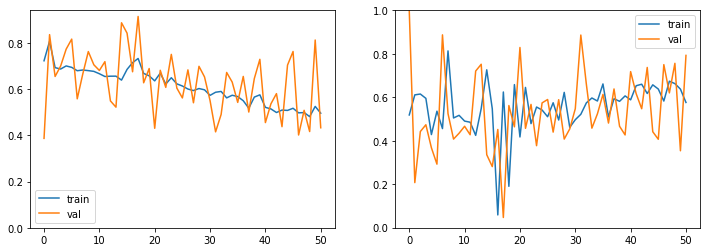

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 14s 3ms/step - loss: 0.6574 - accuracy: 0.6046 - precision: 0.5855 - recall: 0.6404 - f1: 0.5416 - specificity: 0.5834 - negative_predictive_value: 0.7074 - matthews_correlation_coefficient: 0.2457 - equal_error_rate: 0.3617 - val_loss: 0.6282 - val_accuracy: 0.6227 - val_precision: 0.5826 - val_recall: 0.4994 - val_f1: 0.5356 - val_specificity: 0.7186 - val_negative_predictive_value: 0.6470 - val_matthews_correlation_coefficient: 0.2237 - val_equal_error_rate: 0.3526

Epoch 00001: val_equal_error_rate improved from inf to 0.35258, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_04_09-01_05_40.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6098 - accuracy: 0.6833 - precision: 0.6044 - recall: 0.7868 - f1: 0.6779 - specificity: 0.5957 - negative_predictive_value: 0.7935 - matthews_correlation_coefficient: 0.3898 - equal

4610/4610 [==============================] - 13s 3ms/step - loss: 0.5134 - accuracy: 0.7306 - precision: 0.6639 - recall: 0.8143 - f1: 0.7242 - specificity: 0.6674 - negative_predictive_value: 0.8260 - matthews_correlation_coefficient: 0.4857 - equal_error_rate: 0.2565 - val_loss: 0.5276 - val_accuracy: 0.7077 - val_precision: 0.6644 - val_recall: 0.6775 - val_f1: 0.6692 - val_specificity: 0.7288 - val_negative_predictive_value: 0.7438 - val_matthews_correlation_coefficient: 0.4072 - val_equal_error_rate: 0.2928

Epoch 00013: val_equal_error_rate did not improve from 0.27933
Epoch 14/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4968 - accuracy: 0.7434 - precision: 0.6768 - recall: 0.8100 - f1: 0.7340 - specificity: 0.6786 - negative_predictive_value: 0.8070 - matthews_correlation_coefficient: 0.4861 - equal_error_rate: 0.2510 - val_loss: 0.5424 - val_accuracy: 0.7025 - val_precision: 0.6195 - val_recall: 0.8272 - val_f1: 0.7067 - val_specificity: 0.5993 - val

4610/4610 [==============================] - 13s 3ms/step - loss: 0.4864 - accuracy: 0.7523 - precision: 0.7018 - recall: 0.7982 - f1: 0.7386 - specificity: 0.7218 - negative_predictive_value: 0.8238 - matthews_correlation_coefficient: 0.5226 - equal_error_rate: 0.2366 - val_loss: 0.5254 - val_accuracy: 0.7268 - val_precision: 0.6648 - val_recall: 0.7545 - val_f1: 0.7057 - val_specificity: 0.7010 - val_negative_predictive_value: 0.7860 - val_matthews_correlation_coefficient: 0.4532 - val_equal_error_rate: 0.2710

Epoch 00026: val_equal_error_rate did not improve from 0.26927
Epoch 27/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4665 - accuracy: 0.7616 - precision: 0.7011 - recall: 0.8194 - f1: 0.7508 - specificity: 0.7159 - negative_predictive_value: 0.8397 - matthews_correlation_coefficient: 0.5378 - equal_error_rate: 0.2276 - val_loss: 0.5184 - val_accuracy: 0.7311 - val_precision: 0.6938 - val_recall: 0.7001 - val_f1: 0.6955 - val_specificity: 0.7557 - val

4610/4610 [==============================] - 13s 3ms/step - loss: 0.4647 - accuracy: 0.7657 - precision: 0.7191 - recall: 0.7945 - f1: 0.7454 - specificity: 0.7385 - negative_predictive_value: 0.8208 - matthews_correlation_coefficient: 0.5362 - equal_error_rate: 0.2197 - val_loss: 0.5107 - val_accuracy: 0.7381 - val_precision: 0.6683 - val_recall: 0.8054 - val_f1: 0.7294 - val_specificity: 0.6831 - val_negative_predictive_value: 0.8169 - val_matthews_correlation_coefficient: 0.4868 - val_equal_error_rate: 0.2539

Epoch 00039: val_equal_error_rate did not improve from 0.24622
Epoch 40/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4715 - accuracy: 0.7672 - precision: 0.7161 - recall: 0.8206 - f1: 0.7528 - specificity: 0.7302 - negative_predictive_value: 0.8485 - matthews_correlation_coefficient: 0.5572 - equal_error_rate: 0.2147 - val_loss: 0.5251 - val_accuracy: 0.7320 - val_precision: 0.6857 - val_recall: 0.7119 - val_f1: 0.6972 - val_specificity: 0.7428 - val


Epoch 00052: val_equal_error_rate did not improve from 0.24622
Epoch 53/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4430 - accuracy: 0.7835 - precision: 0.7339 - recall: 0.8160 - f1: 0.7673 - specificity: 0.7593 - negative_predictive_value: 0.8485 - matthews_correlation_coefficient: 0.5787 - equal_error_rate: 0.2005 - val_loss: 0.5103 - val_accuracy: 0.7311 - val_precision: 0.7229 - val_recall: 0.6280 - val_f1: 0.6709 - val_specificity: 0.8099 - val_negative_predictive_value: 0.7366 - val_matthews_correlation_coefficient: 0.4485 - val_equal_error_rate: 0.2655

Epoch 00053: val_equal_error_rate did not improve from 0.24622
Epoch 54/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4291 - accuracy: 0.7952 - precision: 0.7474 - recall: 0.8169 - f1: 0.7753 - specificity: 0.7806 - negative_predictive_value: 0.8482 - matthews_correlation_coefficient: 0.5964 - equal_error_rate: 0.2004 - val_loss: 0.5124 - val_accuracy: 0.7320 - val_precision:


Epoch 00066: val_equal_error_rate did not improve from 0.24442
Epoch 67/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4264 - accuracy: 0.7937 - precision: 0.7370 - recall: 0.8297 - f1: 0.7757 - specificity: 0.7635 - negative_predictive_value: 0.8546 - matthews_correlation_coefficient: 0.5923 - equal_error_rate: 0.1959 - val_loss: 0.5260 - val_accuracy: 0.7372 - val_precision: 0.7675 - val_recall: 0.5772 - val_f1: 0.6568 - val_specificity: 0.8616 - val_negative_predictive_value: 0.7237 - val_matthews_correlation_coefficient: 0.4640 - val_equal_error_rate: 0.2567

Epoch 00067: val_equal_error_rate did not improve from 0.24442
Epoch 68/100
4610/4610 [==============================] - 14s 3ms/step - loss: 0.4291 - accuracy: 0.7928 - precision: 0.7582 - recall: 0.8058 - f1: 0.7729 - specificity: 0.7887 - negative_predictive_value: 0.8399 - matthews_correlation_coefficient: 0.5959 - equal_error_rate: 0.1956 - val_loss: 0.5153 - val_accuracy: 0.7329 - val_precision:


Epoch 00080: val_equal_error_rate did not improve from 0.24397
Epoch 81/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4273 - accuracy: 0.7946 - precision: 0.7498 - recall: 0.8254 - f1: 0.7783 - specificity: 0.7752 - negative_predictive_value: 0.8511 - matthews_correlation_coefficient: 0.6007 - equal_error_rate: 0.1937 - val_loss: 0.5335 - val_accuracy: 0.7381 - val_precision: 0.7378 - val_recall: 0.6330 - val_f1: 0.6798 - val_specificity: 0.8200 - val_negative_predictive_value: 0.7404 - val_matthews_correlation_coefficient: 0.4654 - val_equal_error_rate: 0.2601

Epoch 00081: val_equal_error_rate did not improve from 0.24397
Epoch 82/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4185 - accuracy: 0.7959 - precision: 0.7435 - recall: 0.8139 - f1: 0.7722 - specificity: 0.7588 - negative_predictive_value: 0.8332 - matthews_correlation_coefficient: 0.5757 - equal_error_rate: 0.1946 - val_loss: 0.5479 - val_accuracy: 0.7268 - val_precision:


Epoch 00094: val_equal_error_rate improved from 0.24307 to 0.23899, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_04_09-01_05_40.h5
Epoch 95/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3899 - accuracy: 0.8180 - precision: 0.7779 - recall: 0.8250 - f1: 0.7963 - specificity: 0.8126 - negative_predictive_value: 0.8546 - matthews_correlation_coefficient: 0.6350 - equal_error_rate: 0.1756 - val_loss: 0.5227 - val_accuracy: 0.7424 - val_precision: 0.6790 - val_recall: 0.7933 - val_f1: 0.7307 - val_specificity: 0.7038 - val_negative_predictive_value: 0.8135 - val_matthews_correlation_coefficient: 0.4948 - val_equal_error_rate: 0.2479

Epoch 00095: val_equal_error_rate did not improve from 0.23899
Epoch 96/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4136 - accuracy: 0.8082 - precision: 0.7587 - recall: 0.8530 - f1: 0.7967 - specificity: 0.7799 - negative_predictive_value: 0.8733 - matthews_correlation_coeff

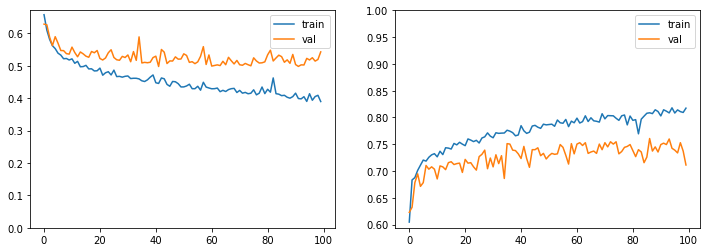

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5989 - accuracy: 0.7289 - precision: 0.9684 - recall: 0.7359 - f1: 0.8208 - specificity: 0.6908 - negative_predictive_value: 0.2146 - matthews_correlation_coefficient: 0.2753 - equal_error_rate: 0.2266 - val_loss: 0.6308 - val_accuracy: 0.6461 - val_precision: 0.9887 - val_recall: 0.6239 - val_f1: 0.7638 - val_specificity: 0.9134 - val_negative_predictive_value: 0.1735 - val_matthews_correlation_coefficient: 0.2933 - val_equal_error_rate: 0.1926

Epoch 00001: val_equal_error_rate improved from inf to 0.19264, saving model to ../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4924 - accuracy: 0.7423 - precision: 0.9845 - recall: 0.7314 - f1: 0.8237 - specificity: 0.8558 - negative_predictive_value: 0.2575 - matthews_correlation_coefficient: 0.3712 - equal_erro

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3456 - accuracy: 0.8681 - precision: 0.9840 - recall: 0.8702 - f1: 0.9227 - specificity: 0.8161 - negative_predictive_value: 0.3633 - matthews_correlation_coefficient: 0.4839 - equal_error_rate: 0.1240 - val_loss: 0.3402 - val_accuracy: 0.8812 - val_precision: 0.9858 - val_recall: 0.8862 - val_f1: 0.9331 - val_specificity: 0.8579 - val_negative_predictive_value: 0.3927 - val_matthews_correlation_coefficient: 0.5284 - val_equal_error_rate: 0.1247

Epoch 00013: val_equal_error_rate improved from 0.12486 to 0.12472, saving model to ../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5
Epoch 14/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3321 - accuracy: 0.8725 - precision: 0.9857 - recall: 0.8773 - f1: 0.9277 - specificity: 0.8520 - negative_predictive_value: 0.3930 - matthews_correlation_coefficient: 0.5177 - equal_error_rate: 0.1299 - val_loss: 0.3575 - val_accuracy: 0.864

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3157 - accuracy: 0.8805 - precision: 0.9874 - recall: 0.8843 - f1: 0.9324 - specificity: 0.8489 - negative_predictive_value: 0.3814 - matthews_correlation_coefficient: 0.5145 - equal_error_rate: 0.1024 - val_loss: 0.3903 - val_accuracy: 0.8569 - val_precision: 0.9894 - val_recall: 0.8557 - val_f1: 0.9175 - val_specificity: 0.9004 - val_negative_predictive_value: 0.3476 - val_matthews_correlation_coefficient: 0.5027 - val_equal_error_rate: 0.1047

Epoch 00026: val_equal_error_rate improved from 0.11119 to 0.10469, saving model to ../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5
Epoch 27/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3078 - accuracy: 0.8822 - precision: 0.9885 - recall: 0.8848 - f1: 0.9329 - specificity: 0.8589 - negative_predictive_value: 0.3911 - matthews_correlation_coefficient: 0.5252 - equal_error_rate: 0.0966 - val_loss: 0.2249 - val_accuracy: 0.923

4610/4610 [==============================] - 13s 3ms/step - loss: 0.2912 - accuracy: 0.8894 - precision: 0.9877 - recall: 0.8918 - f1: 0.9369 - specificity: 0.8514 - negative_predictive_value: 0.4049 - matthews_correlation_coefficient: 0.5328 - equal_error_rate: 0.1016 - val_loss: 0.3974 - val_accuracy: 0.8508 - val_precision: 0.9892 - val_recall: 0.8476 - val_f1: 0.9126 - val_specificity: 0.9013 - val_negative_predictive_value: 0.3362 - val_matthews_correlation_coefficient: 0.4919 - val_equal_error_rate: 0.0986

Epoch 00039: val_equal_error_rate improved from 0.09878 to 0.09860, saving model to ../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5
Epoch 40/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2803 - accuracy: 0.8883 - precision: 0.9878 - recall: 0.8889 - f1: 0.9352 - specificity: 0.8263 - negative_predictive_value: 0.3974 - matthews_correlation_coefficient: 0.5203 - equal_error_rate: 0.1081 - val_loss: 0.3686 - val_accuracy: 0.856


Epoch 00052: val_equal_error_rate did not improve from 0.09091
Epoch 53/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2680 - accuracy: 0.8924 - precision: 0.9888 - recall: 0.8933 - f1: 0.9381 - specificity: 0.8736 - negative_predictive_value: 0.4265 - matthews_correlation_coefficient: 0.5580 - equal_error_rate: 0.0835 - val_loss: 0.3557 - val_accuracy: 0.8612 - val_precision: 0.9904 - val_recall: 0.8583 - val_f1: 0.9193 - val_specificity: 0.9077 - val_negative_predictive_value: 0.3543 - val_matthews_correlation_coefficient: 0.5124 - val_equal_error_rate: 0.0964

Epoch 00053: val_equal_error_rate did not improve from 0.09091
Epoch 54/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2778 - accuracy: 0.8857 - precision: 0.9855 - recall: 0.8871 - f1: 0.9329 - specificity: 0.8682 - negative_predictive_value: 0.4159 - matthews_correlation_coefficient: 0.5422 - equal_error_rate: 0.0788 - val_loss: 0.5071 - val_accuracy: 0.7840 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.2606 - accuracy: 0.8896 - precision: 0.9898 - recall: 0.8879 - f1: 0.9356 - specificity: 0.8777 - negative_predictive_value: 0.4030 - matthews_correlation_coefficient: 0.5436 - equal_error_rate: 0.0847 - val_loss: 0.3738 - val_accuracy: 0.8508 - val_precision: 0.9924 - val_recall: 0.8464 - val_f1: 0.9132 - val_specificity: 0.9271 - val_negative_predictive_value: 0.3446 - val_matthews_correlation_coefficient: 0.5086 - val_equal_error_rate: 0.0897

Epoch 00066: val_equal_error_rate did not improve from 0.08800
Epoch 67/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2582 - accuracy: 0.8920 - precision: 0.9891 - recall: 0.8928 - f1: 0.9376 - specificity: 0.8900 - negative_predictive_value: 0.4323 - matthews_correlation_coefficient: 0.5660 - equal_error_rate: 0.0793 - val_loss: 0.3743 - val_accuracy: 0.8526 - val_precision: 0.9903 - val_recall: 0.8494 - val_f1: 0.9141 - val_specificity: 0.9124 - val


Epoch 00079: val_equal_error_rate did not improve from 0.08714
Epoch 80/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2340 - accuracy: 0.9017 - precision: 0.9914 - recall: 0.9033 - f1: 0.9446 - specificity: 0.8955 - negative_predictive_value: 0.4480 - matthews_correlation_coefficient: 0.5857 - equal_error_rate: 0.0720 - val_loss: 0.2882 - val_accuracy: 0.8838 - val_precision: 0.9896 - val_recall: 0.8844 - val_f1: 0.9337 - val_specificity: 0.8985 - val_negative_predictive_value: 0.4084 - val_matthews_correlation_coefficient: 0.5559 - val_equal_error_rate: 0.0889

Epoch 00080: val_equal_error_rate did not improve from 0.08714
Epoch 81/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2354 - accuracy: 0.9009 - precision: 0.9914 - recall: 0.9005 - f1: 0.9432 - specificity: 0.8891 - negative_predictive_value: 0.4384 - matthews_correlation_coefficient: 0.5755 - equal_error_rate: 0.0651 - val_loss: 0.3008 - val_accuracy: 0.8751 - val_precision:


Epoch 00093: val_equal_error_rate did not improve from 0.08189
Epoch 94/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2218 - accuracy: 0.9085 - precision: 0.9919 - recall: 0.9056 - f1: 0.9463 - specificity: 0.9145 - negative_predictive_value: 0.4584 - matthews_correlation_coefficient: 0.6003 - equal_error_rate: 0.0775 - val_loss: 0.4309 - val_accuracy: 0.8222 - val_precision: 0.9934 - val_recall: 0.8136 - val_f1: 0.8941 - val_specificity: 0.9383 - val_negative_predictive_value: 0.3015 - val_matthews_correlation_coefficient: 0.4683 - val_equal_error_rate: 0.0891

Epoch 00094: val_equal_error_rate did not improve from 0.08189
Epoch 95/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2303 - accuracy: 0.9013 - precision: 0.9901 - recall: 0.8999 - f1: 0.9421 - specificity: 0.9018 - negative_predictive_value: 0.4460 - matthews_correlation_coefficient: 0.5835 - equal_error_rate: 0.0570 - val_loss: 0.3022 - val_accuracy: 0.8794 - val_precision:

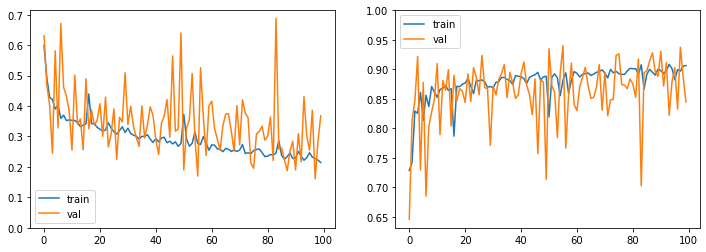

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5635 - accuracy: 0.6985 - precision: 0.9947 - recall: 0.6988 - f1: 0.8141 - specificity: 0.5089 - negative_predictive_value: 0.0330 - matthews_correlation_coefficient: 0.0869 - equal_error_rate: 0.0953 - val_loss: 0.4059 - val_accuracy: 0.6886 - val_precision: 0.9929 - val_recall: 0.6915 - val_f1: 0.8141 - val_specificity: 0.5000 - val_negative_predictive_value: 0.0268 - val_matthews_correlation_coefficient: 0.0696 - val_equal_error_rate: 0.1614

Epoch 00001: val_equal_error_rate improved from inf to 0.16144, saving model to ../models/autoencoders_requirements/washed_out_2020_04_09-01_48_25.h5
Epoch 2/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.4958 - accuracy: 0.6768 - precision: 0.9980 - recall: 0.6767 - f1: 0.7974 - specificity: 0.5053 - negative_predictive_value: 0.0599 - matthews_correlation_coefficient: 0.1070 - equal_error_ra


Epoch 00013: val_equal_error_rate improved from 0.13196 to 0.12136, saving model to ../models/autoencoders_requirements/washed_out_2020_04_09-01_48_25.h5
Epoch 14/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.2351 - accuracy: 0.8835 - precision: 0.9979 - recall: 0.8787 - f1: 0.9326 - specificity: 0.5887 - negative_predictive_value: 0.1264 - matthews_correlation_coefficient: 0.2316 - equal_error_rate: 0.0180 - val_loss: 0.3633 - val_accuracy: 0.7910 - val_precision: 0.9948 - val_recall: 0.7940 - val_f1: 0.8825 - val_specificity: 0.5417 - val_negative_predictive_value: 0.0440 - val_matthews_correlation_coefficient: 0.1196 - val_equal_error_rate: 0.1298

Epoch 00014: val_equal_error_rate did not improve from 0.12136
Epoch 15/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.2291 - accuracy: 0.8857 - precision: 0.9983 - recall: 0.8860 - f1: 0.9378 - specificity: 0.5851 - negative_predictive_value: 0.0900 - matthews_correlation_coefficient: 0


Epoch 00027: val_equal_error_rate did not improve from 0.12136
Epoch 28/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.1928 - accuracy: 0.9271 - precision: 0.9982 - recall: 0.9294 - f1: 0.9617 - specificity: 0.5773 - negative_predictive_value: 0.2030 - matthews_correlation_coefficient: 0.3068 - equal_error_rate: 0.0147 - val_loss: 0.1961 - val_accuracy: 0.9350 - val_precision: 0.9938 - val_recall: 0.9411 - val_f1: 0.9665 - val_specificity: 0.4167 - val_negative_predictive_value: 0.1076 - val_matthews_correlation_coefficient: 0.1906 - val_equal_error_rate: 0.1346

Epoch 00028: val_equal_error_rate did not improve from 0.12136
Epoch 29/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.1891 - accuracy: 0.8809 - precision: 0.9991 - recall: 0.8827 - f1: 0.9356 - specificity: 0.6011 - negative_predictive_value: 0.1206 - matthews_correlation_coefficient: 0.2385 - equal_error_rate: 0.0153 - val_loss: 0.1727 - val_accuracy: 0.9462 - val_precision:


Epoch 00041: val_equal_error_rate did not improve from 0.12136
Epoch 42/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.1695 - accuracy: 0.9165 - precision: 0.9989 - recall: 0.9164 - f1: 0.9548 - specificity: 0.6348 - negative_predictive_value: 0.1620 - matthews_correlation_coefficient: 0.2911 - equal_error_rate: 0.0107 - val_loss: 0.1818 - val_accuracy: 0.9410 - val_precision: 0.9947 - val_recall: 0.9469 - val_f1: 0.9700 - val_specificity: 0.5000 - val_negative_predictive_value: 0.1516 - val_matthews_correlation_coefficient: 0.2526 - val_equal_error_rate: 0.1329

Epoch 00042: val_equal_error_rate did not improve from 0.12136
Epoch 43/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.1861 - accuracy: 0.9043 - precision: 0.9991 - recall: 0.9058 - f1: 0.9472 - specificity: 0.6631 - negative_predictive_value: 0.1973 - matthews_correlation_coefficient: 0.3148 - equal_error_rate: 0.0145 - val_loss: 0.1381 - val_accuracy: 0.9601 - val_precision:


Epoch 00055: val_equal_error_rate did not improve from 0.12136
Epoch 56/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.1343 - accuracy: 0.9419 - precision: 0.9991 - recall: 0.9430 - f1: 0.9699 - specificity: 0.6879 - negative_predictive_value: 0.1789 - matthews_correlation_coefficient: 0.3249 - equal_error_rate: 0.0085 - val_loss: 0.1266 - val_accuracy: 0.9670 - val_precision: 0.9923 - val_recall: 0.9748 - val_f1: 0.9833 - val_specificity: 0.2917 - val_negative_predictive_value: 0.2063 - val_matthews_correlation_coefficient: 0.2194 - val_equal_error_rate: 0.1337

Epoch 00056: val_equal_error_rate did not improve from 0.12136
Epoch 57/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.1303 - accuracy: 0.9518 - precision: 0.9989 - recall: 0.9514 - f1: 0.9741 - specificity: 0.6199 - negative_predictive_value: 0.2573 - matthews_correlation_coefficient: 0.3608 - equal_error_rate: 0.0083 - val_loss: 0.2071 - val_accuracy: 0.9098 - val_precision:

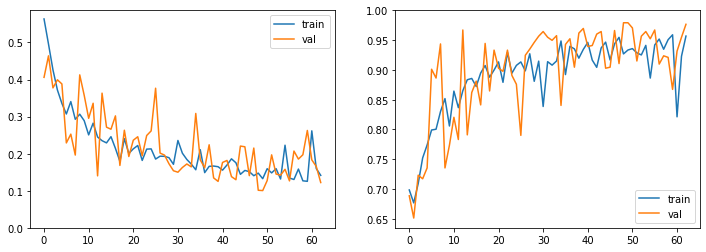

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 14s 3ms/step - loss: 0.6662 - accuracy: 0.5755 - precision: 0.9593 - recall: 0.5719 - f1: 0.7018 - specificity: 0.6102 - negative_predictive_value: 0.1034 - matthews_correlation_coefficient: 0.1107 - equal_error_rate: 0.3439 - val_loss: 0.6526 - val_accuracy: 0.5568 - val_precision: 0.9710 - val_recall: 0.5384 - val_f1: 0.6909 - val_specificity: 0.7901 - val_negative_predictive_value: 0.1108 - val_matthews_correlation_coefficient: 0.1627 - val_equal_error_rate: 0.3058

Epoch 00001: val_equal_error_rate improved from inf to 0.30580, saving model to ../models/autoencoders_requirements/pixelation_2020_04_09-02_00_17.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6521 - accuracy: 0.6093 - precision: 0.9597 - recall: 0.6126 - f1: 0.7345 - specificity: 0.6407 - negative_predictive_value: 0.1251 - matthews_correlation_coefficient: 0.1403 - equal_error_ra

4610/4610 [==============================] - 13s 3ms/step - loss: 0.5479 - accuracy: 0.6996 - precision: 0.9748 - recall: 0.6967 - f1: 0.8093 - specificity: 0.7488 - negative_predictive_value: 0.1574 - matthews_correlation_coefficient: 0.2389 - equal_error_rate: 0.2416 - val_loss: 0.4210 - val_accuracy: 0.8005 - val_precision: 0.9640 - val_recall: 0.8188 - val_f1: 0.8851 - val_specificity: 0.5730 - val_negative_predictive_value: 0.1921 - val_matthews_correlation_coefficient: 0.2461 - val_equal_error_rate: 0.2734

Epoch 00014: val_equal_error_rate improved from 0.27686 to 0.27342, saving model to ../models/autoencoders_requirements/pixelation_2020_04_09-02_00_17.h5
Epoch 15/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5408 - accuracy: 0.6896 - precision: 0.9758 - recall: 0.6837 - f1: 0.7992 - specificity: 0.7616 - negative_predictive_value: 0.1592 - matthews_correlation_coefficient: 0.2424 - equal_error_rate: 0.2379 - val_loss: 0.4123 - val_accuracy: 0.7632 - 

4610/4610 [==============================] - 13s 3ms/step - loss: 0.5250 - accuracy: 0.7072 - precision: 0.9732 - recall: 0.7047 - f1: 0.8154 - specificity: 0.7501 - negative_predictive_value: 0.1583 - matthews_correlation_coefficient: 0.2409 - equal_error_rate: 0.2403 - val_loss: 0.3423 - val_accuracy: 0.8578 - val_precision: 0.9509 - val_recall: 0.8965 - val_f1: 0.9226 - val_specificity: 0.3548 - val_negative_predictive_value: 0.2082 - val_matthews_correlation_coefficient: 0.1975 - val_equal_error_rate: 0.2852

Epoch 00027: val_equal_error_rate did not improve from 0.26287
Epoch 28/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5258 - accuracy: 0.7178 - precision: 0.9759 - recall: 0.7147 - f1: 0.8224 - specificity: 0.7500 - negative_predictive_value: 0.1677 - matthews_correlation_coefficient: 0.2546 - equal_error_rate: 0.2488 - val_loss: 0.4351 - val_accuracy: 0.7615 - val_precision: 0.9654 - val_recall: 0.7746 - val_f1: 0.8589 - val_specificity: 0.6169 - val


Epoch 00040: val_equal_error_rate did not improve from 0.25709
Epoch 41/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4859 - accuracy: 0.7217 - precision: 0.9798 - recall: 0.7144 - f1: 0.8247 - specificity: 0.7943 - negative_predictive_value: 0.1773 - matthews_correlation_coefficient: 0.2788 - equal_error_rate: 0.2180 - val_loss: 0.4383 - val_accuracy: 0.7554 - val_precision: 0.9716 - val_recall: 0.7621 - val_f1: 0.8537 - val_specificity: 0.7045 - val_negative_predictive_value: 0.1769 - val_matthews_correlation_coefficient: 0.2613 - val_equal_error_rate: 0.2606

Epoch 00041: val_equal_error_rate did not improve from 0.25709
Epoch 42/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5264 - accuracy: 0.6616 - precision: 0.9773 - recall: 0.6507 - f1: 0.7719 - specificity: 0.8097 - negative_predictive_value: 0.1652 - matthews_correlation_coefficient: 0.2523 - equal_error_rate: 0.2346 - val_loss: 0.4517 - val_accuracy: 0.7199 - val_precision:


Epoch 00054: val_equal_error_rate did not improve from 0.25306
Epoch 55/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4873 - accuracy: 0.7052 - precision: 0.9813 - recall: 0.6975 - f1: 0.8119 - specificity: 0.8025 - negative_predictive_value: 0.1764 - matthews_correlation_coefficient: 0.2755 - equal_error_rate: 0.2005 - val_loss: 0.3021 - val_accuracy: 0.8638 - val_precision: 0.9522 - val_recall: 0.9026 - val_f1: 0.9264 - val_specificity: 0.3687 - val_negative_predictive_value: 0.2298 - val_matthews_correlation_coefficient: 0.2168 - val_equal_error_rate: 0.2655

Epoch 00055: val_equal_error_rate did not improve from 0.25306
Epoch 56/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4823 - accuracy: 0.7271 - precision: 0.9807 - recall: 0.7198 - f1: 0.8287 - specificity: 0.7759 - negative_predictive_value: 0.1764 - matthews_correlation_coefficient: 0.2759 - equal_error_rate: 0.2095 - val_loss: 0.3655 - val_accuracy: 0.7997 - val_precision:


Epoch 00068: val_equal_error_rate did not improve from 0.25306
Epoch 69/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4794 - accuracy: 0.7289 - precision: 0.9803 - recall: 0.7238 - f1: 0.8301 - specificity: 0.7856 - negative_predictive_value: 0.1782 - matthews_correlation_coefficient: 0.2815 - equal_error_rate: 0.2016 - val_loss: 0.3298 - val_accuracy: 0.8135 - val_precision: 0.9576 - val_recall: 0.8412 - val_f1: 0.8947 - val_specificity: 0.4788 - val_negative_predictive_value: 0.1909 - val_matthews_correlation_coefficient: 0.2142 - val_equal_error_rate: 0.2692

Epoch 00069: val_equal_error_rate did not improve from 0.25306
Epoch 70/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4788 - accuracy: 0.7323 - precision: 0.9790 - recall: 0.7267 - f1: 0.8318 - specificity: 0.7775 - negative_predictive_value: 0.1796 - matthews_correlation_coefficient: 0.2808 - equal_error_rate: 0.2157 - val_loss: 0.3383 - val_accuracy: 0.8361 - val_precision:


Epoch 00082: val_equal_error_rate did not improve from 0.25306
Epoch 83/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4593 - accuracy: 0.7364 - precision: 0.9811 - recall: 0.7301 - f1: 0.8357 - specificity: 0.8143 - negative_predictive_value: 0.1901 - matthews_correlation_coefficient: 0.3019 - equal_error_rate: 0.1998 - val_loss: 0.3388 - val_accuracy: 0.8578 - val_precision: 0.9525 - val_recall: 0.8937 - val_f1: 0.9220 - val_specificity: 0.3847 - val_negative_predictive_value: 0.2092 - val_matthews_correlation_coefficient: 0.2107 - val_equal_error_rate: 0.2700

Epoch 00083: val_equal_error_rate did not improve from 0.25306
Epoch 84/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4571 - accuracy: 0.7416 - precision: 0.9811 - recall: 0.7380 - f1: 0.8401 - specificity: 0.8117 - negative_predictive_value: 0.1958 - matthews_correlation_coefficient: 0.3065 - equal_error_rate: 0.2030 - val_loss: 0.3199 - val_accuracy: 0.8482 - val_precision:

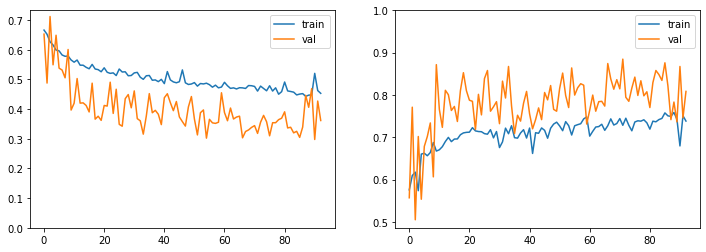

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5753 - accuracy: 0.7115 - precision: 0.8896 - recall: 0.7133 - f1: 0.7805 - specificity: 0.7131 - negative_predictive_value: 0.4461 - matthews_correlation_coefficient: 0.3825 - equal_error_rate: 0.2641 - val_loss: 0.5207 - val_accuracy: 0.7268 - val_precision: 0.9152 - val_recall: 0.6881 - val_f1: 0.7850 - val_specificity: 0.8218 - val_negative_predictive_value: 0.4831 - val_matthews_correlation_coefficient: 0.4505 - val_equal_error_rate: 0.2620

Epoch 00001: val_equal_error_rate improved from inf to 0.26202, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_04_09-02_20_15.h5
Epoch 2/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.5478 - accuracy: 0.7202 - precision: 0.9171 - recall: 0.6773 - f1: 0.7774 - specificity: 0.8278 - negative_predictive_value: 0.4768 - matthews_correlation_coefficient: 0.4451 - equal_er

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5118 - accuracy: 0.7477 - precision: 0.9252 - recall: 0.7152 - f1: 0.8049 - specificity: 0.8374 - negative_predictive_value: 0.5128 - matthews_correlation_coefficient: 0.4911 - equal_error_rate: 0.2303 - val_loss: 0.5610 - val_accuracy: 0.7216 - val_precision: 0.9223 - val_recall: 0.6756 - val_f1: 0.7791 - val_specificity: 0.8420 - val_negative_predictive_value: 0.4793 - val_matthews_correlation_coefficient: 0.4557 - val_equal_error_rate: 0.2321

Epoch 00014: val_equal_error_rate did not improve from 0.22313
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5068 - accuracy: 0.7512 - precision: 0.9163 - recall: 0.7289 - f1: 0.8100 - specificity: 0.8135 - negative_predictive_value: 0.5187 - matthews_correlation_coefficient: 0.4847 - equal_error_rate: 0.2314 - val_loss: 0.6903 - val_accuracy: 0.7025 - val_precision: 0.9252 - val_recall: 0.6462 - val_f1: 0.7604 - val_specificity: 0.8541 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4921 - accuracy: 0.7564 - precision: 0.9171 - recall: 0.7332 - f1: 0.8115 - specificity: 0.8100 - negative_predictive_value: 0.5210 - matthews_correlation_coefficient: 0.4865 - equal_error_rate: 0.2173 - val_loss: 0.5426 - val_accuracy: 0.7311 - val_precision: 0.9163 - val_recall: 0.6938 - val_f1: 0.7887 - val_specificity: 0.8217 - val_negative_predictive_value: 0.4886 - val_matthews_correlation_coefficient: 0.4566 - val_equal_error_rate: 0.2209

Epoch 00027: val_equal_error_rate did not improve from 0.22083
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4893 - accuracy: 0.7616 - precision: 0.9150 - recall: 0.7475 - f1: 0.8208 - specificity: 0.8038 - negative_predictive_value: 0.5372 - matthews_correlation_coefficient: 0.4989 - equal_error_rate: 0.2121 - val_loss: 0.5652 - val_accuracy: 0.7251 - val_precision: 0.9213 - val_recall: 0.6814 - val_f1: 0.7825 - val_specificity: 0.8392 - val


Epoch 00040: val_equal_error_rate did not improve from 0.21817
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4787 - accuracy: 0.7698 - precision: 0.9157 - recall: 0.7595 - f1: 0.8273 - specificity: 0.7991 - negative_predictive_value: 0.5478 - matthews_correlation_coefficient: 0.5081 - equal_error_rate: 0.2116 - val_loss: 0.4986 - val_accuracy: 0.7650 - val_precision: 0.9128 - val_recall: 0.7481 - val_f1: 0.8215 - val_specificity: 0.8001 - val_negative_predictive_value: 0.5314 - val_matthews_correlation_coefficient: 0.4932 - val_equal_error_rate: 0.2230

Epoch 00041: val_equal_error_rate did not improve from 0.21817
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4808 - accuracy: 0.7711 - precision: 0.9106 - recall: 0.7695 - f1: 0.8319 - specificity: 0.7799 - negative_predictive_value: 0.5467 - matthews_correlation_coefficient: 0.4997 - equal_error_rate: 0.2144 - val_loss: 0.5045 - val_accuracy: 0.7485 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4673 - accuracy: 0.7753 - precision: 0.9160 - recall: 0.7669 - f1: 0.8328 - specificity: 0.8043 - negative_predictive_value: 0.5458 - matthews_correlation_coefficient: 0.5119 - equal_error_rate: 0.2049 - val_loss: 0.5207 - val_accuracy: 0.7459 - val_precision: 0.9184 - val_recall: 0.7142 - val_f1: 0.8028 - val_specificity: 0.8218 - val_negative_predictive_value: 0.5055 - val_matthews_correlation_coefficient: 0.4764 - val_equal_error_rate: 0.2225

Epoch 00054: val_equal_error_rate did not improve from 0.20874
Epoch 55/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4561 - accuracy: 0.7826 - precision: 0.9118 - recall: 0.7809 - f1: 0.8391 - specificity: 0.7825 - negative_predictive_value: 0.5485 - matthews_correlation_coefficient: 0.5123 - equal_error_rate: 0.2093 - val_loss: 0.5744 - val_accuracy: 0.7285 - val_precision: 0.9250 - val_recall: 0.6826 - val_f1: 0.7849 - val_specificity: 0.8441 - val


Epoch 00067: val_equal_error_rate did not improve from 0.20874
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4474 - accuracy: 0.7924 - precision: 0.9135 - recall: 0.7889 - f1: 0.8442 - specificity: 0.8009 - negative_predictive_value: 0.5823 - matthews_correlation_coefficient: 0.5400 - equal_error_rate: 0.1992 - val_loss: 0.6120 - val_accuracy: 0.7147 - val_precision: 0.9266 - val_recall: 0.6610 - val_f1: 0.7707 - val_specificity: 0.8526 - val_negative_predictive_value: 0.4718 - val_matthews_correlation_coefficient: 0.4522 - val_equal_error_rate: 0.2189

Epoch 00068: val_equal_error_rate did not improve from 0.20874
Epoch 69/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4488 - accuracy: 0.7839 - precision: 0.9219 - recall: 0.7744 - f1: 0.8395 - specificity: 0.8101 - negative_predictive_value: 0.5648 - matthews_correlation_coefficient: 0.5326 - equal_error_rate: 0.1982 - val_loss: 0.5711 - val_accuracy: 0.7164 - val_precision:


Epoch 00081: val_equal_error_rate did not improve from 0.20714
Epoch 82/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4352 - accuracy: 0.7933 - precision: 0.9313 - recall: 0.7764 - f1: 0.8450 - specificity: 0.8376 - negative_predictive_value: 0.5730 - matthews_correlation_coefficient: 0.5556 - equal_error_rate: 0.1868 - val_loss: 0.4466 - val_accuracy: 0.8014 - val_precision: 0.8941 - val_recall: 0.8269 - val_f1: 0.8589 - val_specificity: 0.7204 - val_negative_predictive_value: 0.5971 - val_matthews_correlation_coefficient: 0.5182 - val_equal_error_rate: 0.2101

Epoch 00082: val_equal_error_rate did not improve from 0.20714
Epoch 83/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4453 - accuracy: 0.7900 - precision: 0.9249 - recall: 0.7808 - f1: 0.8436 - specificity: 0.7949 - negative_predictive_value: 0.5682 - matthews_correlation_coefficient: 0.5352 - equal_error_rate: 0.1954 - val_loss: 0.4887 - val_accuracy: 0.7849 - val_precision:


Epoch 00095: val_equal_error_rate improved from 0.20714 to 0.20551, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_04_09-02_20_15.h5
Epoch 96/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4314 - accuracy: 0.7991 - precision: 0.9272 - recall: 0.7959 - f1: 0.8550 - specificity: 0.8222 - negative_predictive_value: 0.5926 - matthews_correlation_coefficient: 0.5659 - equal_error_rate: 0.1902 - val_loss: 0.5295 - val_accuracy: 0.7424 - val_precision: 0.9232 - val_recall: 0.7043 - val_f1: 0.7982 - val_specificity: 0.8334 - val_negative_predictive_value: 0.4999 - val_matthews_correlation_coefficient: 0.4768 - val_equal_error_rate: 0.2182

Epoch 00096: val_equal_error_rate did not improve from 0.20551
Epoch 97/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4346 - accuracy: 0.7954 - precision: 0.9260 - recall: 0.7846 - f1: 0.8472 - specificity: 0.8186 - negative_predictive_value: 0.5809 - matthews_correlation_coeffici

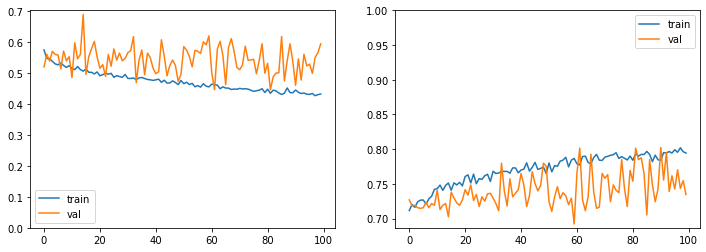

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6588 - accuracy: 0.5525 - precision: 0.8741 - recall: 0.4927 - f1: 0.6197 - specificity: 0.7449 - negative_predictive_value: 0.3035 - matthews_correlation_coefficient: 0.2050 - equal_error_rate: 0.3754 - val_loss: 0.6413 - val_accuracy: 0.5299 - val_precision: 0.8749 - val_recall: 0.4517 - val_f1: 0.5926 - val_specificity: 0.7836 - val_negative_predictive_value: 0.2988 - val_matthews_correlation_coefficient: 0.2019 - val_equal_error_rate: 0.3769

Epoch 00001: val_equal_error_rate improved from inf to 0.37690, saving model to ../models/autoencoders_requirements/eyes_closed_2020_04_09-02_40_49.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6523 - accuracy: 0.5514 - precision: 0.8752 - recall: 0.4808 - f1: 0.6163 - specificity: 0.7810 - negative_predictive_value: 0.3124 - matthews_correlation_coefficient: 0.2210 - equal_error_r


Epoch 00013: val_equal_error_rate did not improve from 0.33000
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6073 - accuracy: 0.6486 - precision: 0.8882 - recall: 0.6222 - f1: 0.7247 - specificity: 0.7286 - negative_predictive_value: 0.3733 - matthews_correlation_coefficient: 0.3022 - equal_error_rate: 0.3109 - val_loss: 0.6438 - val_accuracy: 0.6184 - val_precision: 0.8822 - val_recall: 0.5794 - val_f1: 0.6980 - val_specificity: 0.7396 - val_negative_predictive_value: 0.3446 - val_matthews_correlation_coefficient: 0.2688 - val_equal_error_rate: 0.3319

Epoch 00014: val_equal_error_rate did not improve from 0.33000
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6161 - accuracy: 0.6527 - precision: 0.8888 - recall: 0.6359 - f1: 0.7286 - specificity: 0.7056 - negative_predictive_value: 0.3707 - matthews_correlation_coefficient: 0.2961 - equal_error_rate: 0.3178 - val_loss: 0.7024 - val_accuracy: 0.5603 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5687 - accuracy: 0.6957 - precision: 0.8916 - recall: 0.6867 - f1: 0.7718 - specificity: 0.7214 - negative_predictive_value: 0.4156 - matthews_correlation_coefficient: 0.3532 - equal_error_rate: 0.2882 - val_loss: 0.6882 - val_accuracy: 0.5958 - val_precision: 0.9070 - val_recall: 0.5246 - val_f1: 0.6622 - val_specificity: 0.8203 - val_negative_predictive_value: 0.3410 - val_matthews_correlation_coefficient: 0.2921 - val_equal_error_rate: 0.3170

Epoch 00027: val_equal_error_rate improved from 0.32008 to 0.31699, saving model to ../models/autoencoders_requirements/eyes_closed_2020_04_09-02_40_49.h5
Epoch 28/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5752 - accuracy: 0.6781 - precision: 0.9002 - recall: 0.6624 - f1: 0.7583 - specificity: 0.7480 - negative_predictive_value: 0.4001 - matthews_correlation_coefficient: 0.3497 - equal_error_rate: 0.2833 - val_loss: 0.5149 - val_accuracy: 0.7407 -


Epoch 00040: val_equal_error_rate did not improve from 0.31319
Epoch 41/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5473 - accuracy: 0.7074 - precision: 0.9059 - recall: 0.6970 - f1: 0.7840 - specificity: 0.7543 - negative_predictive_value: 0.4318 - matthews_correlation_coefficient: 0.3893 - equal_error_rate: 0.2659 - val_loss: 0.6201 - val_accuracy: 0.6453 - val_precision: 0.8933 - val_recall: 0.6064 - val_f1: 0.7208 - val_specificity: 0.7577 - val_negative_predictive_value: 0.3666 - val_matthews_correlation_coefficient: 0.3074 - val_equal_error_rate: 0.3182

Epoch 00041: val_equal_error_rate did not improve from 0.31319
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5591 - accuracy: 0.6885 - precision: 0.9010 - recall: 0.6746 - f1: 0.7640 - specificity: 0.7400 - negative_predictive_value: 0.4064 - matthews_correlation_coefficient: 0.3566 - equal_error_rate: 0.2736 - val_loss: 0.6668 - val_accuracy: 0.6167 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5398 - accuracy: 0.7115 - precision: 0.9006 - recall: 0.7031 - f1: 0.7862 - specificity: 0.7459 - negative_predictive_value: 0.4273 - matthews_correlation_coefficient: 0.3821 - equal_error_rate: 0.2677 - val_loss: 0.6011 - val_accuracy: 0.6565 - val_precision: 0.8928 - val_recall: 0.6244 - val_f1: 0.7331 - val_specificity: 0.7512 - val_negative_predictive_value: 0.3761 - val_matthews_correlation_coefficient: 0.3175 - val_equal_error_rate: 0.3072

Epoch 00054: val_equal_error_rate did not improve from 0.30364
Epoch 55/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5292 - accuracy: 0.7245 - precision: 0.8977 - recall: 0.7259 - f1: 0.7984 - specificity: 0.7221 - negative_predictive_value: 0.4522 - matthews_correlation_coefficient: 0.3948 - equal_error_rate: 0.2642 - val_loss: 0.6392 - val_accuracy: 0.6444 - val_precision: 0.9077 - val_recall: 0.5919 - val_f1: 0.7138 - val_specificity: 0.7963 - val


Epoch 00067: val_equal_error_rate did not improve from 0.29380
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5139 - accuracy: 0.7241 - precision: 0.9095 - recall: 0.7164 - f1: 0.7982 - specificity: 0.7475 - negative_predictive_value: 0.4347 - matthews_correlation_coefficient: 0.3984 - equal_error_rate: 0.2490 - val_loss: 0.6400 - val_accuracy: 0.6522 - val_precision: 0.9072 - val_recall: 0.6053 - val_f1: 0.7248 - val_specificity: 0.7954 - val_negative_predictive_value: 0.3769 - val_matthews_correlation_coefficient: 0.3371 - val_equal_error_rate: 0.2897

Epoch 00068: val_equal_error_rate improved from 0.29380 to 0.28970, saving model to ../models/autoencoders_requirements/eyes_closed_2020_04_09-02_40_49.h5
Epoch 69/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5080 - accuracy: 0.7328 - precision: 0.9111 - recall: 0.7265 - f1: 0.8065 - specificity: 0.7575 - negative_predictive_value: 0.4530 - matthews_correlation_coefficient: 

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5214 - accuracy: 0.7169 - precision: 0.9069 - recall: 0.7094 - f1: 0.7930 - specificity: 0.7504 - negative_predictive_value: 0.4379 - matthews_correlation_coefficient: 0.3971 - equal_error_rate: 0.2565 - val_loss: 0.6278 - val_accuracy: 0.6505 - val_precision: 0.9054 - val_recall: 0.6042 - val_f1: 0.7229 - val_specificity: 0.7929 - val_negative_predictive_value: 0.3762 - val_matthews_correlation_coefficient: 0.3342 - val_equal_error_rate: 0.2901

Epoch 00081: val_equal_error_rate did not improve from 0.28787
Epoch 82/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5114 - accuracy: 0.7289 - precision: 0.9114 - recall: 0.7225 - f1: 0.8017 - specificity: 0.7542 - negative_predictive_value: 0.4565 - matthews_correlation_coefficient: 0.4178 - equal_error_rate: 0.2474 - val_loss: 0.5368 - val_accuracy: 0.7129 - val_precision: 0.8658 - val_recall: 0.7385 - val_f1: 0.7967 - val_specificity: 0.6167 - val


Epoch 00094: val_equal_error_rate did not improve from 0.27450
Epoch 95/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4931 - accuracy: 0.7508 - precision: 0.9076 - recall: 0.7538 - f1: 0.8215 - specificity: 0.7463 - negative_predictive_value: 0.4779 - matthews_correlation_coefficient: 0.4381 - equal_error_rate: 0.2427 - val_loss: 0.6481 - val_accuracy: 0.6418 - val_precision: 0.8967 - val_recall: 0.5969 - val_f1: 0.7144 - val_specificity: 0.7726 - val_negative_predictive_value: 0.3672 - val_matthews_correlation_coefficient: 0.3121 - val_equal_error_rate: 0.3069

Epoch 00095: val_equal_error_rate did not improve from 0.27450
Epoch 96/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5080 - accuracy: 0.7208 - precision: 0.9151 - recall: 0.7047 - f1: 0.7889 - specificity: 0.7532 - negative_predictive_value: 0.4494 - matthews_correlation_coefficient: 0.4112 - equal_error_rate: 0.2353 - val_loss: 0.6441 - val_accuracy: 0.6652 - val_precision:

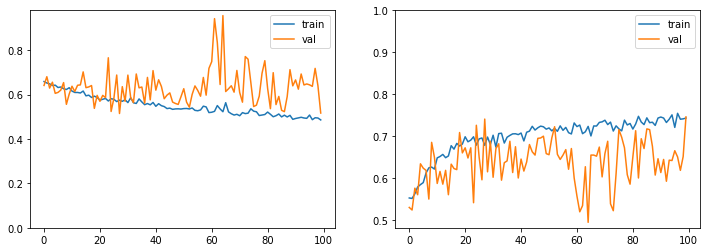

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5573 - accuracy: 0.7028 - precision: 0.8020 - recall: 0.6558 - f1: 0.6860 - specificity: 0.7602 - negative_predictive_value: 0.6676 - matthews_correlation_coefficient: 0.4396 - equal_error_rate: 0.2491 - val_loss: 0.5058 - val_accuracy: 0.7415 - val_precision: 0.9142 - val_recall: 0.5939 - val_f1: 0.7177 - val_specificity: 0.9276 - val_negative_predictive_value: 0.6402 - val_matthews_correlation_coefficient: 0.5373 - val_equal_error_rate: 0.2248

Epoch 00001: val_equal_error_rate improved from inf to 0.22476, saving model to ../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4543 - accuracy: 0.7664 - precision: 0.8284 - recall: 0.7535 - f1: 0.7783 - specificity: 0.7858 - negative_predictive_value: 0.7263 - matthews_correlation_coefficient: 0.5467 - equal_e


Epoch 00013: val_equal_error_rate did not improve from 0.18896
Epoch 14/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3683 - accuracy: 0.8184 - precision: 0.8724 - recall: 0.8078 - f1: 0.8341 - specificity: 0.8458 - negative_predictive_value: 0.7781 - matthews_correlation_coefficient: 0.6519 - equal_error_rate: 0.1611 - val_loss: 0.3910 - val_accuracy: 0.8023 - val_precision: 0.7803 - val_recall: 0.9034 - val_f1: 0.8363 - val_specificity: 0.6736 - val_negative_predictive_value: 0.8433 - val_matthews_correlation_coefficient: 0.5997 - val_equal_error_rate: 0.1818

Epoch 00014: val_equal_error_rate improved from 0.18896 to 0.18182, saving model to ../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5
Epoch 15/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3678 - accuracy: 0.8245 - precision: 0.8708 - recall: 0.8205 - f1: 0.8405 - specificity: 0.8427 - negative_predictive_value: 0.7910 - matthews_correlation_coeffic


Epoch 00026: val_equal_error_rate did not improve from 0.16743
Epoch 27/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3302 - accuracy: 0.8456 - precision: 0.8899 - recall: 0.8344 - f1: 0.8588 - specificity: 0.8657 - negative_predictive_value: 0.8021 - matthews_correlation_coefficient: 0.6960 - equal_error_rate: 0.1447 - val_loss: 0.3578 - val_accuracy: 0.8283 - val_precision: 0.8565 - val_recall: 0.8319 - val_f1: 0.8434 - val_specificity: 0.8213 - val_negative_predictive_value: 0.7906 - val_matthews_correlation_coefficient: 0.6501 - val_equal_error_rate: 0.1625

Epoch 00027: val_equal_error_rate improved from 0.16743 to 0.16253, saving model to ../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3285 - accuracy: 0.8412 - precision: 0.8900 - recall: 0.8176 - f1: 0.8474 - specificity: 0.8680 - negative_predictive_value: 0.7889 - matthews_correlation_coeffic

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3225 - accuracy: 0.8460 - precision: 0.8857 - recall: 0.8392 - f1: 0.8566 - specificity: 0.8586 - negative_predictive_value: 0.8130 - matthews_correlation_coefficient: 0.6980 - equal_error_rate: 0.1428 - val_loss: 0.3423 - val_accuracy: 0.8378 - val_precision: 0.8495 - val_recall: 0.8629 - val_f1: 0.8557 - val_specificity: 0.8038 - val_negative_predictive_value: 0.8189 - val_matthews_correlation_coefficient: 0.6675 - val_equal_error_rate: 0.1576

Epoch 00040: val_equal_error_rate did not improve from 0.15654
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3143 - accuracy: 0.8505 - precision: 0.8946 - recall: 0.8318 - f1: 0.8599 - specificity: 0.8757 - negative_predictive_value: 0.8033 - matthews_correlation_coefficient: 0.7026 - equal_error_rate: 0.1427 - val_loss: 0.3624 - val_accuracy: 0.8309 - val_precision: 0.8855 - val_recall: 0.8016 - val_f1: 0.8407 - val_specificity: 0.8665 - val


Epoch 00053: val_equal_error_rate did not improve from 0.15014
Epoch 54/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2916 - accuracy: 0.8623 - precision: 0.9003 - recall: 0.8517 - f1: 0.8733 - specificity: 0.8719 - negative_predictive_value: 0.8226 - matthews_correlation_coefficient: 0.7229 - equal_error_rate: 0.1342 - val_loss: 0.3512 - val_accuracy: 0.8343 - val_precision: 0.8730 - val_recall: 0.8227 - val_f1: 0.8468 - val_specificity: 0.8476 - val_negative_predictive_value: 0.7872 - val_matthews_correlation_coefficient: 0.6652 - val_equal_error_rate: 0.1640

Epoch 00054: val_equal_error_rate did not improve from 0.15014
Epoch 55/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3110 - accuracy: 0.8488 - precision: 0.8977 - recall: 0.8300 - f1: 0.8585 - specificity: 0.8734 - negative_predictive_value: 0.7981 - matthews_correlation_coefficient: 0.6992 - equal_error_rate: 0.1321 - val_loss: 0.3407 - val_accuracy: 0.8387 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.2808 - accuracy: 0.8668 - precision: 0.8983 - recall: 0.8569 - f1: 0.8753 - specificity: 0.8730 - negative_predictive_value: 0.8255 - matthews_correlation_coefficient: 0.7267 - equal_error_rate: 0.1288 - val_loss: 0.3253 - val_accuracy: 0.8448 - val_precision: 0.8905 - val_recall: 0.8233 - val_f1: 0.8550 - val_specificity: 0.8704 - val_negative_predictive_value: 0.7916 - val_matthews_correlation_coefficient: 0.6879 - val_equal_error_rate: 0.1513

Epoch 00067: val_equal_error_rate did not improve from 0.14781
Epoch 68/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2842 - accuracy: 0.8644 - precision: 0.9119 - recall: 0.8438 - f1: 0.8749 - specificity: 0.8958 - negative_predictive_value: 0.8103 - matthews_correlation_coefficient: 0.7303 - equal_error_rate: 0.1284 - val_loss: 0.3625 - val_accuracy: 0.8222 - val_precision: 0.8050 - val_recall: 0.8967 - val_f1: 0.8476 - val_specificity: 0.7217 - val

4610/4610 [==============================] - 13s 3ms/step - loss: 0.2694 - accuracy: 0.8746 - precision: 0.9160 - recall: 0.8593 - f1: 0.8855 - specificity: 0.8910 - negative_predictive_value: 0.8331 - matthews_correlation_coefficient: 0.7491 - equal_error_rate: 0.1217 - val_loss: 0.3263 - val_accuracy: 0.8448 - val_precision: 0.8488 - val_recall: 0.8773 - val_f1: 0.8624 - val_specificity: 0.8003 - val_negative_predictive_value: 0.8355 - val_matthews_correlation_coefficient: 0.6809 - val_equal_error_rate: 0.1461

Epoch 00080: val_equal_error_rate improved from 0.14614 to 0.14613, saving model to ../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5
Epoch 81/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2763 - accuracy: 0.8672 - precision: 0.9070 - recall: 0.8559 - f1: 0.8786 - specificity: 0.8880 - negative_predictive_value: 0.8256 - matthews_correlation_coefficient: 0.7381 - equal_error_rate: 0.1236 - val_loss: 0.3258 - val_accuracy: 0.

4610/4610 [==============================] - 13s 3ms/step - loss: 0.2931 - accuracy: 0.8616 - precision: 0.9072 - recall: 0.8475 - f1: 0.8718 - specificity: 0.8834 - negative_predictive_value: 0.8251 - matthews_correlation_coefficient: 0.7315 - equal_error_rate: 0.1208 - val_loss: 0.3249 - val_accuracy: 0.8430 - val_precision: 0.8350 - val_recall: 0.9001 - val_f1: 0.8653 - val_specificity: 0.7704 - val_negative_predictive_value: 0.8554 - val_matthews_correlation_coefficient: 0.6803 - val_equal_error_rate: 0.1467

Epoch 00093: val_equal_error_rate did not improve from 0.14350
Epoch 94/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2629 - accuracy: 0.8718 - precision: 0.9143 - recall: 0.8553 - f1: 0.8823 - specificity: 0.8973 - negative_predictive_value: 0.8252 - matthews_correlation_coefficient: 0.7460 - equal_error_rate: 0.1152 - val_loss: 0.3378 - val_accuracy: 0.8439 - val_precision: 0.8292 - val_recall: 0.9047 - val_f1: 0.8645 - val_specificity: 0.7584 - val

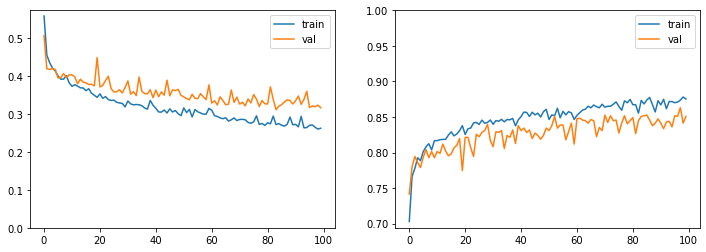

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5931 - accuracy: 0.7046 - precision: 0.8938 - recall: 0.6926 - f1: 0.7772 - specificity: 0.7560 - negative_predictive_value: 0.4457 - matthews_correlation_coefficient: 0.3895 - equal_error_rate: 0.2773 - val_loss: 0.5535 - val_accuracy: 0.7008 - val_precision: 0.9002 - val_recall: 0.6777 - val_f1: 0.7721 - val_specificity: 0.7648 - val_negative_predictive_value: 0.4360 - val_matthews_correlation_coefficient: 0.3854 - val_equal_error_rate: 0.2904

Epoch 00001: val_equal_error_rate improved from inf to 0.29045, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_04_09-03_23_09.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5703 - accuracy: 0.7087 - precision: 0.9088 - recall: 0.6749 - f1: 0.7733 - specificity: 0.7810 - negative_predictive_value: 0.4399 - matthews_correlation_coefficient: 0.3985 - equal_erro


Epoch 00013: val_equal_error_rate did not improve from 0.26414
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5613 - accuracy: 0.7091 - precision: 0.9097 - recall: 0.6747 - f1: 0.7734 - specificity: 0.7889 - negative_predictive_value: 0.4397 - matthews_correlation_coefficient: 0.4018 - equal_error_rate: 0.2605 - val_loss: 0.5906 - val_accuracy: 0.6947 - val_precision: 0.9123 - val_recall: 0.6590 - val_f1: 0.7643 - val_specificity: 0.8011 - val_negative_predictive_value: 0.4337 - val_matthews_correlation_coefficient: 0.3986 - val_equal_error_rate: 0.2710

Epoch 00014: val_equal_error_rate did not improve from 0.26414
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5601 - accuracy: 0.7085 - precision: 0.9163 - recall: 0.6760 - f1: 0.7763 - specificity: 0.7930 - negative_predictive_value: 0.4426 - matthews_correlation_coefficient: 0.4133 - equal_error_rate: 0.2545 - val_loss: 0.5674 - val_accuracy: 0.6990 - val_precision:


Epoch 00027: val_equal_error_rate did not improve from 0.26414
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5498 - accuracy: 0.7063 - precision: 0.9130 - recall: 0.6751 - f1: 0.7746 - specificity: 0.8105 - negative_predictive_value: 0.4520 - matthews_correlation_coefficient: 0.4200 - equal_error_rate: 0.2610 - val_loss: 0.6025 - val_accuracy: 0.6895 - val_precision: 0.9140 - val_recall: 0.6493 - val_f1: 0.7585 - val_specificity: 0.8074 - val_negative_predictive_value: 0.4282 - val_matthews_correlation_coefficient: 0.3950 - val_equal_error_rate: 0.2714

Epoch 00028: val_equal_error_rate did not improve from 0.26414
Epoch 29/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5474 - accuracy: 0.7063 - precision: 0.9184 - recall: 0.6681 - f1: 0.7720 - specificity: 0.7988 - negative_predictive_value: 0.4384 - matthews_correlation_coefficient: 0.4123 - equal_error_rate: 0.2532 - val_loss: 0.5311 - val_accuracy: 0.7103 - val_precision:


Epoch 00041: val_equal_error_rate did not improve from 0.26414
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5467 - accuracy: 0.7089 - precision: 0.9179 - recall: 0.6746 - f1: 0.7762 - specificity: 0.8157 - negative_predictive_value: 0.4484 - matthews_correlation_coefficient: 0.4230 - equal_error_rate: 0.2518 - val_loss: 0.6029 - val_accuracy: 0.6938 - val_precision: 0.9149 - val_recall: 0.6554 - val_f1: 0.7631 - val_specificity: 0.8068 - val_negative_predictive_value: 0.4317 - val_matthews_correlation_coefficient: 0.3999 - val_equal_error_rate: 0.2761

Epoch 00042: val_equal_error_rate did not improve from 0.26414
Epoch 43/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5434 - accuracy: 0.7143 - precision: 0.9157 - recall: 0.6856 - f1: 0.7831 - specificity: 0.8059 - negative_predictive_value: 0.4524 - matthews_correlation_coefficient: 0.4246 - equal_error_rate: 0.2643 - val_loss: 0.5273 - val_accuracy: 0.7173 - val_precision:


Epoch 00055: val_equal_error_rate did not improve from 0.26414
Epoch 56/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5437 - accuracy: 0.7180 - precision: 0.9196 - recall: 0.6839 - f1: 0.7827 - specificity: 0.7914 - negative_predictive_value: 0.4480 - matthews_correlation_coefficient: 0.4217 - equal_error_rate: 0.2428 - val_loss: 0.5388 - val_accuracy: 0.7121 - val_precision: 0.8809 - val_recall: 0.7178 - val_f1: 0.7902 - val_specificity: 0.6937 - val_negative_predictive_value: 0.4435 - val_matthews_correlation_coefficient: 0.3651 - val_equal_error_rate: 0.2766

Epoch 00056: val_equal_error_rate did not improve from 0.26414
Epoch 57/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5420 - accuracy: 0.7271 - precision: 0.9181 - recall: 0.7042 - f1: 0.7950 - specificity: 0.8036 - negative_predictive_value: 0.4705 - matthews_correlation_coefficient: 0.4437 - equal_error_rate: 0.2535 - val_loss: 0.5582 - val_accuracy: 0.7086 - val_precision:

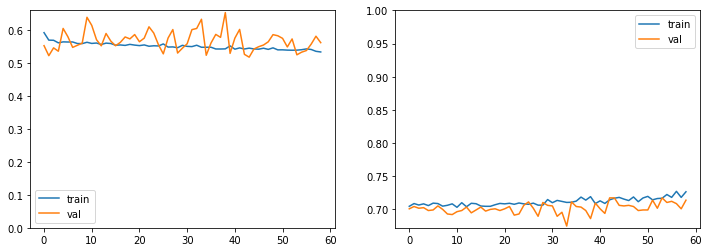

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6232 - accuracy: 0.6438 - precision: 0.7483 - recall: 0.5569 - f1: 0.6091 - specificity: 0.7657 - negative_predictive_value: 0.6113 - matthews_correlation_coefficient: 0.3390 - equal_error_rate: 0.3130 - val_loss: 0.5668 - val_accuracy: 0.6930 - val_precision: 0.7214 - val_recall: 0.7241 - val_f1: 0.7193 - val_specificity: 0.6637 - val_negative_predictive_value: 0.6645 - val_matthews_correlation_coefficient: 0.3868 - val_equal_error_rate: 0.3062

Epoch 00001: val_equal_error_rate improved from inf to 0.30621, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_09-03_35_11.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5625 - accuracy: 0.7230 - precision: 0.7497 - recall: 0.7558 - f1: 0.7453 - specificity: 0.6946 - negative_predictive_value: 0.7185 - matthews_correlation_coefficient: 0.4589 - 


Epoch 00013: val_equal_error_rate did not improve from 0.21880
Epoch 14/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4534 - accuracy: 0.7807 - precision: 0.7978 - recall: 0.8123 - f1: 0.8009 - specificity: 0.7503 - negative_predictive_value: 0.7737 - matthews_correlation_coefficient: 0.5670 - equal_error_rate: 0.2156 - val_loss: 0.4750 - val_accuracy: 0.7424 - val_precision: 0.8402 - val_recall: 0.6495 - val_f1: 0.7307 - val_specificity: 0.8547 - val_negative_predictive_value: 0.6690 - val_matthews_correlation_coefficient: 0.5064 - val_equal_error_rate: 0.2211

Epoch 00014: val_equal_error_rate did not improve from 0.21880
Epoch 15/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4569 - accuracy: 0.7716 - precision: 0.8000 - recall: 0.7896 - f1: 0.7886 - specificity: 0.7573 - negative_predictive_value: 0.7517 - matthews_correlation_coefficient: 0.5489 - equal_error_rate: 0.2197 - val_loss: 0.4461 - val_accuracy: 0.7849 - val_precision:


Epoch 00026: val_equal_error_rate did not improve from 0.19876
Epoch 27/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4265 - accuracy: 0.7844 - precision: 0.8104 - recall: 0.8007 - f1: 0.8018 - specificity: 0.7745 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.5757 - equal_error_rate: 0.2083 - val_loss: 0.4159 - val_accuracy: 0.7962 - val_precision: 0.8047 - val_recall: 0.8292 - val_f1: 0.8143 - val_specificity: 0.7590 - val_negative_predictive_value: 0.7890 - val_matthews_correlation_coefficient: 0.5908 - val_equal_error_rate: 0.2061

Epoch 00027: val_equal_error_rate did not improve from 0.19876
Epoch 28/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4232 - accuracy: 0.7924 - precision: 0.8121 - recall: 0.8095 - f1: 0.8070 - specificity: 0.7725 - negative_predictive_value: 0.7776 - matthews_correlation_coefficient: 0.5857 - equal_error_rate: 0.2051 - val_loss: 0.4229 - val_accuracy: 0.7962 - val_precision:

4610/4610 [==============================] - 13s 3ms/step - loss: 0.4012 - accuracy: 0.8046 - precision: 0.8110 - recall: 0.8391 - f1: 0.8202 - specificity: 0.7618 - negative_predictive_value: 0.8052 - matthews_correlation_coefficient: 0.6083 - equal_error_rate: 0.1886 - val_loss: 0.4030 - val_accuracy: 0.8040 - val_precision: 0.8099 - val_recall: 0.8419 - val_f1: 0.8233 - val_specificity: 0.7631 - val_negative_predictive_value: 0.8009 - val_matthews_correlation_coefficient: 0.6077 - val_equal_error_rate: 0.1853

Epoch 00040: val_equal_error_rate improved from 0.18606 to 0.18533, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_09-03_35_11.h5
Epoch 41/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4000 - accuracy: 0.8052 - precision: 0.8309 - recall: 0.8148 - f1: 0.8199 - specificity: 0.7975 - negative_predictive_value: 0.7799 - matthews_correlation_coefficient: 0.6114 - equal_error_rate: 0.1914 - val_loss: 0.4113 - val_accur


Epoch 00053: val_equal_error_rate did not improve from 0.18533
Epoch 54/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3863 - accuracy: 0.8113 - precision: 0.8306 - recall: 0.8199 - f1: 0.8213 - specificity: 0.7983 - negative_predictive_value: 0.7940 - matthews_correlation_coefficient: 0.6212 - equal_error_rate: 0.1804 - val_loss: 0.4089 - val_accuracy: 0.8066 - val_precision: 0.8391 - val_recall: 0.7984 - val_f1: 0.8160 - val_specificity: 0.8187 - val_negative_predictive_value: 0.7712 - val_matthews_correlation_coefficient: 0.6137 - val_equal_error_rate: 0.1868

Epoch 00054: val_equal_error_rate did not improve from 0.18533
Epoch 55/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3958 - accuracy: 0.8091 - precision: 0.8316 - recall: 0.8180 - f1: 0.8197 - specificity: 0.7929 - negative_predictive_value: 0.7874 - matthews_correlation_coefficient: 0.6146 - equal_error_rate: 0.1898 - val_loss: 0.4024 - val_accuracy: 0.8109 - val_precision:

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3735 - accuracy: 0.8249 - precision: 0.8552 - recall: 0.8221 - f1: 0.8330 - specificity: 0.8291 - negative_predictive_value: 0.7938 - matthews_correlation_coefficient: 0.6498 - equal_error_rate: 0.1689 - val_loss: 0.4432 - val_accuracy: 0.7901 - val_precision: 0.7505 - val_recall: 0.9287 - val_f1: 0.8283 - val_specificity: 0.6275 - val_negative_predictive_value: 0.8792 - val_matthews_correlation_coefficient: 0.5914 - val_equal_error_rate: 0.1818

Epoch 00067: val_equal_error_rate did not improve from 0.17934
Epoch 68/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3858 - accuracy: 0.8200 - precision: 0.8357 - recall: 0.8349 - f1: 0.8311 - specificity: 0.7941 - negative_predictive_value: 0.8097 - matthews_correlation_coefficient: 0.6369 - equal_error_rate: 0.1714 - val_loss: 0.4092 - val_accuracy: 0.8127 - val_precision: 0.8056 - val_recall: 0.8684 - val_f1: 0.8331 - val_specificity: 0.7493 - val


Epoch 00080: val_equal_error_rate did not improve from 0.17660
Epoch 81/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3617 - accuracy: 0.8286 - precision: 0.8545 - recall: 0.8285 - f1: 0.8382 - specificity: 0.8235 - negative_predictive_value: 0.7997 - matthews_correlation_coefficient: 0.6530 - equal_error_rate: 0.1747 - val_loss: 0.4101 - val_accuracy: 0.8023 - val_precision: 0.7713 - val_recall: 0.9061 - val_f1: 0.8313 - val_specificity: 0.6752 - val_negative_predictive_value: 0.8558 - val_matthews_correlation_coefficient: 0.6034 - val_equal_error_rate: 0.1777

Epoch 00081: val_equal_error_rate did not improve from 0.17660
Epoch 82/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3550 - accuracy: 0.8395 - precision: 0.8499 - recall: 0.8597 - f1: 0.8532 - specificity: 0.8176 - negative_predictive_value: 0.8289 - matthews_correlation_coefficient: 0.6778 - equal_error_rate: 0.1558 - val_loss: 0.4143 - val_accuracy: 0.8066 - val_precision:


Epoch 00094: val_equal_error_rate did not improve from 0.16662
Epoch 95/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3501 - accuracy: 0.8410 - precision: 0.8606 - recall: 0.8499 - f1: 0.8514 - specificity: 0.8302 - negative_predictive_value: 0.8256 - matthews_correlation_coefficient: 0.6830 - equal_error_rate: 0.1501 - val_loss: 0.4099 - val_accuracy: 0.8222 - val_precision: 0.8182 - val_recall: 0.8664 - val_f1: 0.8402 - val_specificity: 0.7721 - val_negative_predictive_value: 0.8273 - val_matthews_correlation_coefficient: 0.6419 - val_equal_error_rate: 0.1894

Epoch 00095: val_equal_error_rate did not improve from 0.16662
Epoch 96/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3493 - accuracy: 0.8377 - precision: 0.8574 - recall: 0.8498 - f1: 0.8503 - specificity: 0.8259 - negative_predictive_value: 0.8260 - matthews_correlation_coefficient: 0.6793 - equal_error_rate: 0.1600 - val_loss: 0.4392 - val_accuracy: 0.8040 - val_precision:

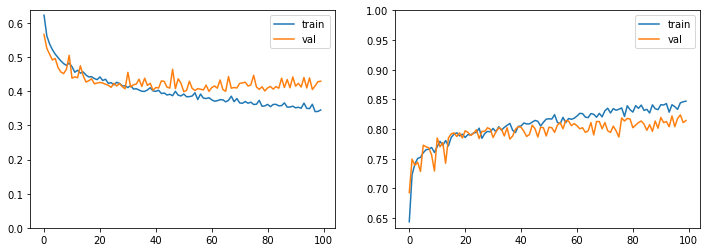

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6355 - accuracy: 0.5265 - precision: 0.8918 - recall: 0.4499 - f1: 0.5933 - specificity: 0.7927 - negative_predictive_value: 0.2821 - matthews_correlation_coefficient: 0.2049 - equal_error_rate: 0.3670 - val_loss: 0.6334 - val_accuracy: 0.4796 - val_precision: 0.9367 - val_recall: 0.3645 - val_f1: 0.5220 - val_specificity: 0.9081 - val_negative_predictive_value: 0.2794 - val_matthews_correlation_coefficient: 0.2424 - val_equal_error_rate: 0.3491

Epoch 00001: val_equal_error_rate improved from inf to 0.34911, saving model to ../models/autoencoders_requirements/red_eyes_2020_04_09-03_57_03.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6191 - accuracy: 0.5373 - precision: 0.9170 - recall: 0.4535 - f1: 0.5989 - specificity: 0.8439 - negative_predictive_value: 0.2984 - matthews_correlation_coefficient: 0.2521 - equal_error_rate

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5671 - accuracy: 0.6460 - precision: 0.9170 - recall: 0.5992 - f1: 0.7186 - specificity: 0.8064 - negative_predictive_value: 0.3604 - matthews_correlation_coefficient: 0.3341 - equal_error_rate: 0.2823 - val_loss: 0.5380 - val_accuracy: 0.6687 - val_precision: 0.9256 - val_recall: 0.6348 - val_f1: 0.7513 - val_specificity: 0.8089 - val_negative_predictive_value: 0.3767 - val_matthews_correlation_coefficient: 0.3661 - val_equal_error_rate: 0.2728

Epoch 00014: val_equal_error_rate improved from 0.28115 to 0.27285, saving model to ../models/autoencoders_requirements/red_eyes_2020_04_09-03_57_03.h5
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5614 - accuracy: 0.6462 - precision: 0.9259 - recall: 0.6043 - f1: 0.7267 - specificity: 0.7941 - negative_predictive_value: 0.3526 - matthews_correlation_coefficient: 0.3351 - equal_error_rate: 0.2830 - val_loss: 0.5558 - val_accuracy: 0.6470 - va


Epoch 00027: val_equal_error_rate did not improve from 0.26383
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5595 - accuracy: 0.6770 - precision: 0.9193 - recall: 0.6519 - f1: 0.7500 - specificity: 0.7685 - negative_predictive_value: 0.4078 - matthews_correlation_coefficient: 0.3676 - equal_error_rate: 0.2775 - val_loss: 0.5993 - val_accuracy: 0.6236 - val_precision: 0.9455 - val_recall: 0.5531 - val_f1: 0.6964 - val_specificity: 0.8845 - val_negative_predictive_value: 0.3510 - val_matthews_correlation_coefficient: 0.3600 - val_equal_error_rate: 0.2798

Epoch 00028: val_equal_error_rate did not improve from 0.26383
Epoch 29/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5333 - accuracy: 0.6848 - precision: 0.9304 - recall: 0.6462 - f1: 0.7593 - specificity: 0.8054 - negative_predictive_value: 0.3843 - matthews_correlation_coefficient: 0.3763 - equal_error_rate: 0.2637 - val_loss: 0.5151 - val_accuracy: 0.7147 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5190 - accuracy: 0.7169 - precision: 0.9234 - recall: 0.7059 - f1: 0.7956 - specificity: 0.7601 - negative_predictive_value: 0.4148 - matthews_correlation_coefficient: 0.3957 - equal_error_rate: 0.2509 - val_loss: 0.5254 - val_accuracy: 0.6930 - val_precision: 0.9218 - val_recall: 0.6663 - val_f1: 0.7723 - val_specificity: 0.7957 - val_negative_predictive_value: 0.3962 - val_matthews_correlation_coefficient: 0.3831 - val_equal_error_rate: 0.2582

Epoch 00041: val_equal_error_rate did not improve from 0.25071
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5261 - accuracy: 0.7113 - precision: 0.9263 - recall: 0.6913 - f1: 0.7846 - specificity: 0.7873 - negative_predictive_value: 0.4231 - matthews_correlation_coefficient: 0.4069 - equal_error_rate: 0.2475 - val_loss: 0.5523 - val_accuracy: 0.6852 - val_precision: 0.9459 - val_recall: 0.6359 - val_f1: 0.7590 - val_specificity: 0.8689 - val


Epoch 00054: val_equal_error_rate did not improve from 0.24567
Epoch 55/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4984 - accuracy: 0.7273 - precision: 0.9276 - recall: 0.7147 - f1: 0.8054 - specificity: 0.7923 - negative_predictive_value: 0.4286 - matthews_correlation_coefficient: 0.4237 - equal_error_rate: 0.2406 - val_loss: 0.6295 - val_accuracy: 0.6383 - val_precision: 0.9468 - val_recall: 0.5721 - val_f1: 0.7115 - val_specificity: 0.8851 - val_negative_predictive_value: 0.3616 - val_matthews_correlation_coefficient: 0.3753 - val_equal_error_rate: 0.2786

Epoch 00055: val_equal_error_rate did not improve from 0.24567
Epoch 56/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4966 - accuracy: 0.7271 - precision: 0.9313 - recall: 0.7051 - f1: 0.8005 - specificity: 0.8150 - negative_predictive_value: 0.4356 - matthews_correlation_coefficient: 0.4358 - equal_error_rate: 0.2340 - val_loss: 0.5954 - val_accuracy: 0.6678 - val_precision:


Epoch 00068: val_equal_error_rate did not improve from 0.24567
Epoch 69/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4809 - accuracy: 0.7406 - precision: 0.9302 - recall: 0.7262 - f1: 0.8128 - specificity: 0.7956 - negative_predictive_value: 0.4481 - matthews_correlation_coefficient: 0.4435 - equal_error_rate: 0.2353 - val_loss: 0.6341 - val_accuracy: 0.6401 - val_precision: 0.9273 - val_recall: 0.5859 - val_f1: 0.7155 - val_specificity: 0.8337 - val_negative_predictive_value: 0.3583 - val_matthews_correlation_coefficient: 0.3460 - val_equal_error_rate: 0.2902

Epoch 00069: val_equal_error_rate did not improve from 0.24567
Epoch 70/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4854 - accuracy: 0.7390 - precision: 0.9293 - recall: 0.7211 - f1: 0.8090 - specificity: 0.7984 - negative_predictive_value: 0.4464 - matthews_correlation_coefficient: 0.4410 - equal_error_rate: 0.2343 - val_loss: 0.6008 - val_accuracy: 0.6583 - val_precision:


Epoch 00082: val_equal_error_rate did not improve from 0.24380
Epoch 83/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4759 - accuracy: 0.7471 - precision: 0.9289 - recall: 0.7340 - f1: 0.8179 - specificity: 0.7874 - negative_predictive_value: 0.4490 - matthews_correlation_coefficient: 0.4428 - equal_error_rate: 0.2348 - val_loss: 0.6006 - val_accuracy: 0.6730 - val_precision: 0.9349 - val_recall: 0.6258 - val_f1: 0.7482 - val_specificity: 0.8425 - val_negative_predictive_value: 0.3819 - val_matthews_correlation_coefficient: 0.3849 - val_equal_error_rate: 0.2541

Epoch 00083: val_equal_error_rate did not improve from 0.24380
Epoch 84/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4655 - accuracy: 0.7534 - precision: 0.9322 - recall: 0.7444 - f1: 0.8254 - specificity: 0.8031 - negative_predictive_value: 0.4700 - matthews_correlation_coefficient: 0.4681 - equal_error_rate: 0.2203 - val_loss: 0.6380 - val_accuracy: 0.6557 - val_precision:


Epoch 00096: val_equal_error_rate did not improve from 0.24237
Epoch 97/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4623 - accuracy: 0.7603 - precision: 0.9209 - recall: 0.7525 - f1: 0.8248 - specificity: 0.7667 - negative_predictive_value: 0.4614 - matthews_correlation_coefficient: 0.4450 - equal_error_rate: 0.2190 - val_loss: 0.6525 - val_accuracy: 0.6331 - val_precision: 0.9374 - val_recall: 0.5700 - val_f1: 0.7072 - val_specificity: 0.8610 - val_negative_predictive_value: 0.3539 - val_matthews_correlation_coefficient: 0.3541 - val_equal_error_rate: 0.2652

Epoch 00097: val_equal_error_rate did not improve from 0.24237
Epoch 98/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4695 - accuracy: 0.7497 - precision: 0.9380 - recall: 0.7356 - f1: 0.8196 - specificity: 0.8193 - negative_predictive_value: 0.4730 - matthews_correlation_coefficient: 0.4762 - equal_error_rate: 0.2109 - val_loss: 0.7044 - val_accuracy: 0.6141 - val_precision:

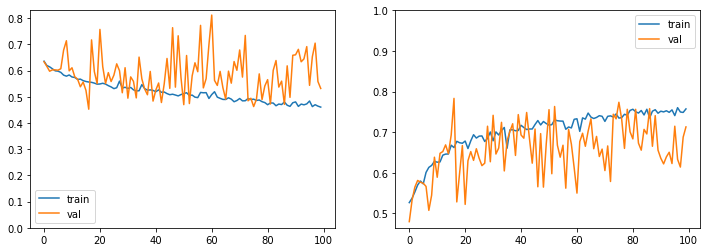

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5080 - accuracy: 0.7174 - precision: 0.8413 - recall: 0.6996 - f1: 0.7535 - specificity: 0.7505 - negative_predictive_value: 0.5704 - matthews_correlation_coefficient: 0.4298 - equal_error_rate: 0.2691 - val_loss: 0.5416 - val_accuracy: 0.6791 - val_precision: 0.9132 - val_recall: 0.5743 - val_f1: 0.7046 - val_specificity: 0.8890 - val_negative_predictive_value: 0.5056 - val_matthews_correlation_coefficient: 0.4401 - val_equal_error_rate: 0.2373

Epoch 00001: val_equal_error_rate improved from inf to 0.23734, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_04_09-04_17_49.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4370 - accuracy: 0.7720 - precision: 0.8766 - recall: 0.7637 - f1: 0.8132 - specificity: 0.7900 - negative_predictive_value: 0.6280 - matthews_correlation_coefficient: 0.5282 - equal

4610/4610 [==============================] - 13s 3ms/step - loss: 0.4037 - accuracy: 0.8037 - precision: 0.9048 - recall: 0.7935 - f1: 0.8415 - specificity: 0.8265 - negative_predictive_value: 0.6676 - matthews_correlation_coefficient: 0.5948 - equal_error_rate: 0.1817 - val_loss: 0.3919 - val_accuracy: 0.8118 - val_precision: 0.8521 - val_recall: 0.8705 - val_f1: 0.8604 - val_specificity: 0.6891 - val_negative_predictive_value: 0.7201 - val_matthews_correlation_coefficient: 0.5655 - val_equal_error_rate: 0.1952

Epoch 00013: val_equal_error_rate improved from 0.19971 to 0.19523, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_04_09-04_17_49.h5
Epoch 14/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3932 - accuracy: 0.8089 - precision: 0.8920 - recall: 0.8141 - f1: 0.8473 - specificity: 0.8011 - negative_predictive_value: 0.6874 - matthews_correlation_coefficient: 0.5962 - equal_error_rate: 0.1787 - val_loss: 0.4387 - val_accuracy: 

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3665 - accuracy: 0.8364 - precision: 0.9088 - recall: 0.8366 - f1: 0.8695 - specificity: 0.8322 - negative_predictive_value: 0.7186 - matthews_correlation_coefficient: 0.6475 - equal_error_rate: 0.1603 - val_loss: 0.3815 - val_accuracy: 0.8361 - val_precision: 0.8833 - val_recall: 0.8704 - val_f1: 0.8762 - val_specificity: 0.7666 - val_negative_predictive_value: 0.7428 - val_matthews_correlation_coefficient: 0.6312 - val_equal_error_rate: 0.1886

Epoch 00026: val_equal_error_rate did not improve from 0.18393
Epoch 27/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3689 - accuracy: 0.8161 - precision: 0.9133 - recall: 0.8018 - f1: 0.8509 - specificity: 0.8448 - negative_predictive_value: 0.6790 - matthews_correlation_coefficient: 0.6181 - equal_error_rate: 0.1602 - val_loss: 0.3663 - val_accuracy: 0.8448 - val_precision: 0.8904 - val_recall: 0.8737 - val_f1: 0.8813 - val_specificity: 0.7817 - val

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3434 - accuracy: 0.8475 - precision: 0.9160 - recall: 0.8526 - f1: 0.8807 - specificity: 0.8360 - negative_predictive_value: 0.7401 - matthews_correlation_coefficient: 0.6717 - equal_error_rate: 0.1468 - val_loss: 0.3815 - val_accuracy: 0.8265 - val_precision: 0.9180 - val_recall: 0.8137 - val_f1: 0.8621 - val_specificity: 0.8520 - val_negative_predictive_value: 0.6906 - val_matthews_correlation_coefficient: 0.6362 - val_equal_error_rate: 0.1656

Epoch 00039: val_equal_error_rate did not improve from 0.16486
Epoch 40/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3447 - accuracy: 0.8449 - precision: 0.9143 - recall: 0.8495 - f1: 0.8790 - specificity: 0.8324 - negative_predictive_value: 0.7316 - matthews_correlation_coefficient: 0.6632 - equal_error_rate: 0.1565 - val_loss: 0.3412 - val_accuracy: 0.8500 - val_precision: 0.8634 - val_recall: 0.9190 - val_f1: 0.8898 - val_specificity: 0.7045 - val

4610/4610 [==============================] - 13s 3ms/step - loss: 0.3226 - accuracy: 0.8607 - precision: 0.9227 - recall: 0.8705 - f1: 0.8947 - specificity: 0.8518 - negative_predictive_value: 0.7653 - matthews_correlation_coefficient: 0.7046 - equal_error_rate: 0.1387 - val_loss: 0.3638 - val_accuracy: 0.8387 - val_precision: 0.9110 - val_recall: 0.8387 - val_f1: 0.8730 - val_specificity: 0.8344 - val_negative_predictive_value: 0.7174 - val_matthews_correlation_coefficient: 0.6502 - val_equal_error_rate: 0.1580

Epoch 00052: val_equal_error_rate did not improve from 0.15621
Epoch 53/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3372 - accuracy: 0.8460 - precision: 0.9164 - recall: 0.8458 - f1: 0.8761 - specificity: 0.8462 - negative_predictive_value: 0.7406 - matthews_correlation_coefficient: 0.6735 - equal_error_rate: 0.1411 - val_loss: 0.3660 - val_accuracy: 0.8317 - val_precision: 0.9138 - val_recall: 0.8249 - val_f1: 0.8666 - val_specificity: 0.8413 - val


Epoch 00065: val_equal_error_rate did not improve from 0.15351
Epoch 66/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3216 - accuracy: 0.8482 - precision: 0.9286 - recall: 0.8410 - f1: 0.8789 - specificity: 0.8611 - negative_predictive_value: 0.7332 - matthews_correlation_coefficient: 0.6799 - equal_error_rate: 0.1346 - val_loss: 0.3309 - val_accuracy: 0.8595 - val_precision: 0.8799 - val_recall: 0.9128 - val_f1: 0.8956 - val_specificity: 0.7464 - val_negative_predictive_value: 0.8030 - val_matthews_correlation_coefficient: 0.6707 - val_equal_error_rate: 0.1728

Epoch 00066: val_equal_error_rate did not improve from 0.15351
Epoch 67/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3087 - accuracy: 0.8670 - precision: 0.9263 - recall: 0.8724 - f1: 0.8968 - specificity: 0.8557 - negative_predictive_value: 0.7665 - matthews_correlation_coefficient: 0.7096 - equal_error_rate: 0.1288 - val_loss: 0.3478 - val_accuracy: 0.8395 - val_precision:


Epoch 00079: val_equal_error_rate did not improve from 0.15351
Epoch 80/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2987 - accuracy: 0.8633 - precision: 0.9254 - recall: 0.8639 - f1: 0.8921 - specificity: 0.8551 - negative_predictive_value: 0.7533 - matthews_correlation_coefficient: 0.6981 - equal_error_rate: 0.1244 - val_loss: 0.3244 - val_accuracy: 0.8595 - val_precision: 0.8763 - val_recall: 0.9191 - val_f1: 0.8965 - val_specificity: 0.7340 - val_negative_predictive_value: 0.8111 - val_matthews_correlation_coefficient: 0.6695 - val_equal_error_rate: 0.1632

Epoch 00080: val_equal_error_rate did not improve from 0.15351
Epoch 81/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2988 - accuracy: 0.8692 - precision: 0.9290 - recall: 0.8740 - f1: 0.8993 - specificity: 0.8585 - negative_predictive_value: 0.7754 - matthews_correlation_coefficient: 0.7178 - equal_error_rate: 0.1267 - val_loss: 0.3624 - val_accuracy: 0.8222 - val_precision:


Epoch 00093: val_equal_error_rate did not improve from 0.15351
Epoch 94/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2864 - accuracy: 0.8748 - precision: 0.9302 - recall: 0.8784 - f1: 0.9023 - specificity: 0.8615 - negative_predictive_value: 0.7787 - matthews_correlation_coefficient: 0.7237 - equal_error_rate: 0.1167 - val_loss: 0.3463 - val_accuracy: 0.8378 - val_precision: 0.9039 - val_recall: 0.8480 - val_f1: 0.8745 - val_specificity: 0.8149 - val_negative_predictive_value: 0.7217 - val_matthews_correlation_coefficient: 0.6438 - val_equal_error_rate: 0.1542

Epoch 00094: val_equal_error_rate did not improve from 0.15351
Epoch 95/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.2896 - accuracy: 0.8705 - precision: 0.9314 - recall: 0.8729 - f1: 0.8998 - specificity: 0.8525 - negative_predictive_value: 0.7540 - matthews_correlation_coefficient: 0.7046 - equal_error_rate: 0.1199 - val_loss: 0.3250 - val_accuracy: 0.8569 - val_precision:

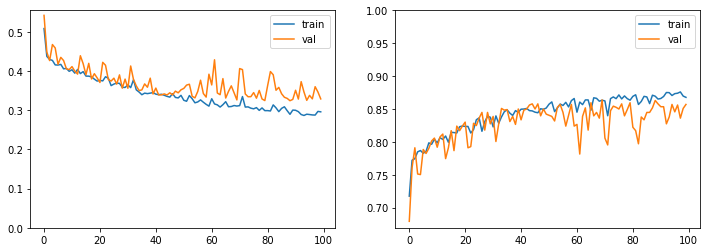

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6276 - accuracy: 0.5846 - precision: 0.8920 - recall: 0.5520 - f1: 0.6761 - specificity: 0.7383 - negative_predictive_value: 0.2938 - matthews_correlation_coefficient: 0.2317 - equal_error_rate: 0.3490 - val_loss: 0.5531 - val_accuracy: 0.5941 - val_precision: 0.9191 - val_recall: 0.5470 - val_f1: 0.6835 - val_specificity: 0.8045 - val_negative_predictive_value: 0.3040 - val_matthews_correlation_coefficient: 0.2796 - val_equal_error_rate: 0.3234

Epoch 00001: val_equal_error_rate improved from inf to 0.32343, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_04_09-04_39_28.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6040 - accuracy: 0.5709 - precision: 0.9259 - recall: 0.5074 - f1: 0.6538 - specificity: 0.8382 - negative_predictive_value: 0.2921 - matthews_correlation_coefficient: 0.2731 - equal

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5544 - accuracy: 0.6597 - precision: 0.9354 - recall: 0.6185 - f1: 0.7400 - specificity: 0.8171 - negative_predictive_value: 0.3468 - matthews_correlation_coefficient: 0.3490 - equal_error_rate: 0.2724 - val_loss: 0.4774 - val_accuracy: 0.7398 - val_precision: 0.9037 - val_recall: 0.7568 - val_f1: 0.8228 - val_specificity: 0.6782 - val_negative_predictive_value: 0.4086 - val_matthews_correlation_coefficient: 0.3681 - val_equal_error_rate: 0.2661

Epoch 00013: val_equal_error_rate did not improve from 0.25641
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5535 - accuracy: 0.6529 - precision: 0.9338 - recall: 0.6121 - f1: 0.7337 - specificity: 0.8253 - negative_predictive_value: 0.3480 - matthews_correlation_coefficient: 0.3499 - equal_error_rate: 0.2629 - val_loss: 0.5888 - val_accuracy: 0.6600 - val_precision: 0.9448 - val_recall: 0.6114 - val_f1: 0.7400 - val_specificity: 0.8589 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5241 - accuracy: 0.6872 - precision: 0.9411 - recall: 0.6549 - f1: 0.7687 - specificity: 0.8306 - negative_predictive_value: 0.3775 - matthews_correlation_coefficient: 0.3920 - equal_error_rate: 0.2529 - val_loss: 0.5429 - val_accuracy: 0.6895 - val_precision: 0.9306 - val_recall: 0.6647 - val_f1: 0.7743 - val_specificity: 0.8068 - val_negative_predictive_value: 0.3739 - val_matthews_correlation_coefficient: 0.3785 - val_equal_error_rate: 0.2683

Epoch 00026: val_equal_error_rate did not improve from 0.24668
Epoch 27/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5208 - accuracy: 0.6748 - precision: 0.9391 - recall: 0.6356 - f1: 0.7557 - specificity: 0.8311 - negative_predictive_value: 0.3622 - matthews_correlation_coefficient: 0.3742 - equal_error_rate: 0.2585 - val_loss: 0.4859 - val_accuracy: 0.7216 - val_precision: 0.9240 - val_recall: 0.7132 - val_f1: 0.8043 - val_specificity: 0.7672 - val


Epoch 00039: val_equal_error_rate did not improve from 0.24668
Epoch 40/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5019 - accuracy: 0.6911 - precision: 0.9462 - recall: 0.6481 - f1: 0.7663 - specificity: 0.8284 - negative_predictive_value: 0.3706 - matthews_correlation_coefficient: 0.3924 - equal_error_rate: 0.2408 - val_loss: 0.4550 - val_accuracy: 0.7511 - val_precision: 0.8963 - val_recall: 0.7767 - val_f1: 0.8309 - val_specificity: 0.6329 - val_negative_predictive_value: 0.4118 - val_matthews_correlation_coefficient: 0.3544 - val_equal_error_rate: 0.2561

Epoch 00040: val_equal_error_rate did not improve from 0.24668
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5086 - accuracy: 0.7039 - precision: 0.9396 - recall: 0.6763 - f1: 0.7822 - specificity: 0.8134 - negative_predictive_value: 0.3882 - matthews_correlation_coefficient: 0.3996 - equal_error_rate: 0.2498 - val_loss: 0.4714 - val_accuracy: 0.7225 - val_precision:


Epoch 00053: val_equal_error_rate did not improve from 0.24668
Epoch 54/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4978 - accuracy: 0.6967 - precision: 0.9421 - recall: 0.6666 - f1: 0.7762 - specificity: 0.8314 - negative_predictive_value: 0.3848 - matthews_correlation_coefficient: 0.4021 - equal_error_rate: 0.2320 - val_loss: 0.5127 - val_accuracy: 0.7164 - val_precision: 0.9187 - val_recall: 0.7091 - val_f1: 0.7996 - val_specificity: 0.7516 - val_negative_predictive_value: 0.3899 - val_matthews_correlation_coefficient: 0.3766 - val_equal_error_rate: 0.2584

Epoch 00054: val_equal_error_rate did not improve from 0.24668
Epoch 55/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4932 - accuracy: 0.7065 - precision: 0.9419 - recall: 0.6769 - f1: 0.7830 - specificity: 0.8097 - negative_predictive_value: 0.3873 - matthews_correlation_coefficient: 0.4022 - equal_error_rate: 0.2347 - val_loss: 0.4473 - val_accuracy: 0.7381 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4813 - accuracy: 0.6957 - precision: 0.9493 - recall: 0.6582 - f1: 0.7735 - specificity: 0.8351 - negative_predictive_value: 0.3781 - matthews_correlation_coefficient: 0.4032 - equal_error_rate: 0.2287 - val_loss: 0.4332 - val_accuracy: 0.7589 - val_precision: 0.8921 - val_recall: 0.7942 - val_f1: 0.8398 - val_specificity: 0.6121 - val_negative_predictive_value: 0.4218 - val_matthews_correlation_coefficient: 0.3566 - val_equal_error_rate: 0.2613

Epoch 00067: val_equal_error_rate did not improve from 0.24668
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4821 - accuracy: 0.7193 - precision: 0.9409 - recall: 0.6883 - f1: 0.7893 - specificity: 0.8210 - negative_predictive_value: 0.4081 - matthews_correlation_coefficient: 0.4200 - equal_error_rate: 0.2342 - val_loss: 0.6148 - val_accuracy: 0.6600 - val_precision: 0.9602 - val_recall: 0.6016 - val_f1: 0.7374 - val_specificity: 0.8986 - val

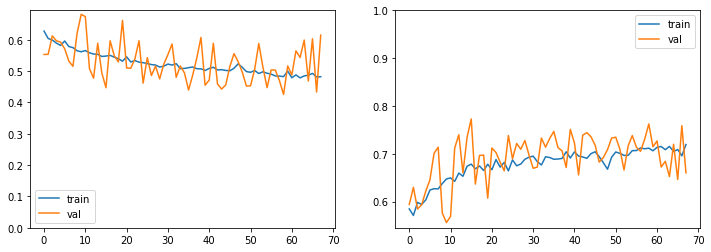

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5842 - accuracy: 0.5384 - precision: 0.9653 - recall: 0.5019 - f1: 0.6557 - specificity: 0.8521 - negative_predictive_value: 0.1793 - matthews_correlation_coefficient: 0.2242 - equal_error_rate: 0.3062 - val_loss: 0.7167 - val_accuracy: 0.4545 - val_precision: 0.9751 - val_recall: 0.3970 - val_f1: 0.5606 - val_specificity: 0.9176 - val_negative_predictive_value: 0.1612 - val_matthews_correlation_coefficient: 0.2063 - val_equal_error_rate: 0.3598

Epoch 00001: val_equal_error_rate improved from inf to 0.35979, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_04_09-04_53_40.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5587 - accuracy: 0.5412 - precision: 0.9667 - recall: 0.5027 - f1: 0.6575 - specificity: 0.8667 - negative_predictive_value: 0.1807 - matthews_correlation_coefficient: 0.2307 - equal_


Epoch 00013: val_equal_error_rate did not improve from 0.22182
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4800 - accuracy: 0.6816 - precision: 0.9752 - recall: 0.6620 - f1: 0.7800 - specificity: 0.8300 - negative_predictive_value: 0.2495 - matthews_correlation_coefficient: 0.3314 - equal_error_rate: 0.2066 - val_loss: 0.5942 - val_accuracy: 0.6080 - val_precision: 0.9743 - val_recall: 0.5745 - val_f1: 0.7209 - val_specificity: 0.8910 - val_negative_predictive_value: 0.2072 - val_matthews_correlation_coefficient: 0.2892 - val_equal_error_rate: 0.2552

Epoch 00014: val_equal_error_rate did not improve from 0.22182
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4600 - accuracy: 0.7267 - precision: 0.9703 - recall: 0.7147 - f1: 0.8180 - specificity: 0.8244 - negative_predictive_value: 0.2832 - matthews_correlation_coefficient: 0.3657 - equal_error_rate: 0.2029 - val_loss: 0.6458 - val_accuracy: 0.6054 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4086 - accuracy: 0.7573 - precision: 0.9801 - recall: 0.7417 - f1: 0.8392 - specificity: 0.8761 - negative_predictive_value: 0.3129 - matthews_correlation_coefficient: 0.4201 - equal_error_rate: 0.1643 - val_loss: 0.3623 - val_accuracy: 0.8014 - val_precision: 0.9620 - val_recall: 0.8099 - val_f1: 0.8787 - val_specificity: 0.7444 - val_negative_predictive_value: 0.3251 - val_matthews_correlation_coefficient: 0.3962 - val_equal_error_rate: 0.1865

Epoch 00027: val_equal_error_rate did not improve from 0.17267
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3984 - accuracy: 0.7761 - precision: 0.9779 - recall: 0.7630 - f1: 0.8535 - specificity: 0.8544 - negative_predictive_value: 0.3256 - matthews_correlation_coefficient: 0.4287 - equal_error_rate: 0.1692 - val_loss: 0.4803 - val_accuracy: 0.7095 - val_precision: 0.9811 - val_recall: 0.6880 - val_f1: 0.8077 - val_specificity: 0.9012 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.3893 - accuracy: 0.7664 - precision: 0.9800 - recall: 0.7557 - f1: 0.8497 - specificity: 0.8645 - negative_predictive_value: 0.3174 - matthews_correlation_coefficient: 0.4253 - equal_error_rate: 0.1524 - val_loss: 0.4433 - val_accuracy: 0.7520 - val_precision: 0.9864 - val_recall: 0.7327 - val_f1: 0.8396 - val_specificity: 0.9228 - val_negative_predictive_value: 0.3028 - val_matthews_correlation_coefficient: 0.4332 - val_equal_error_rate: 0.1603

Epoch 00040: val_equal_error_rate improved from 0.16255 to 0.16026, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_04_09-04_53_40.h5
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3567 - accuracy: 0.8048 - precision: 0.9800 - recall: 0.7986 - f1: 0.8776 - specificity: 0.8872 - negative_predictive_value: 0.3713 - matthews_correlation_coefficient: 0.4864 - equal_error_rate: 0.1432 - val_loss: 1.2007 - val_accuracy: 0

4610/4610 [==============================] - 12s 3ms/step - loss: 0.3481 - accuracy: 0.8091 - precision: 0.9820 - recall: 0.7958 - f1: 0.8775 - specificity: 0.8873 - negative_predictive_value: 0.3589 - matthews_correlation_coefficient: 0.4796 - equal_error_rate: 0.1405 - val_loss: 0.6165 - val_accuracy: 0.6479 - val_precision: 0.9968 - val_recall: 0.6061 - val_f1: 0.7516 - val_specificity: 0.9848 - val_negative_predictive_value: 0.2413 - val_matthews_correlation_coefficient: 0.3732 - val_equal_error_rate: 0.1609

Epoch 00053: val_equal_error_rate did not improve from 0.15376
Epoch 54/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3427 - accuracy: 0.8020 - precision: 0.9804 - recall: 0.7912 - f1: 0.8731 - specificity: 0.8675 - negative_predictive_value: 0.3537 - matthews_correlation_coefficient: 0.4663 - equal_error_rate: 0.1354 - val_loss: 0.6143 - val_accuracy: 0.6427 - val_precision: 0.9926 - val_recall: 0.6048 - val_f1: 0.7493 - val_specificity: 0.9654 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.3766 - accuracy: 0.7659 - precision: 0.9825 - recall: 0.7436 - f1: 0.8396 - specificity: 0.8822 - negative_predictive_value: 0.3283 - matthews_correlation_coefficient: 0.4351 - equal_error_rate: 0.1436 - val_loss: 0.5448 - val_accuracy: 0.6947 - val_precision: 0.9809 - val_recall: 0.6685 - val_f1: 0.7934 - val_specificity: 0.8965 - val_negative_predictive_value: 0.2557 - val_matthews_correlation_coefficient: 0.3635 - val_equal_error_rate: 0.1757

Epoch 00066: val_equal_error_rate did not improve from 0.14852
Epoch 67/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3234 - accuracy: 0.8236 - precision: 0.9831 - recall: 0.8119 - f1: 0.8869 - specificity: 0.8644 - negative_predictive_value: 0.3792 - matthews_correlation_coefficient: 0.4936 - equal_error_rate: 0.1226 - val_loss: 0.6051 - val_accuracy: 0.6722 - val_precision: 0.9931 - val_recall: 0.6383 - val_f1: 0.7753 - val_specificity: 0.9654 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.3014 - accuracy: 0.8393 - precision: 0.9857 - recall: 0.8330 - f1: 0.9015 - specificity: 0.9030 - negative_predictive_value: 0.4111 - matthews_correlation_coefficient: 0.5366 - equal_error_rate: 0.1102 - val_loss: 1.0691 - val_accuracy: 0.5429 - val_precision: 0.9942 - val_recall: 0.4875 - val_f1: 0.6520 - val_specificity: 0.9773 - val_negative_predictive_value: 0.1938 - val_matthews_correlation_coefficient: 0.2943 - val_equal_error_rate: 0.2254

Epoch 00079: val_equal_error_rate did not improve from 0.13749
Epoch 80/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3547 - accuracy: 0.8063 - precision: 0.9828 - recall: 0.7966 - f1: 0.8749 - specificity: 0.8833 - negative_predictive_value: 0.3976 - matthews_correlation_coefficient: 0.4995 - equal_error_rate: 0.1323 - val_loss: 0.8070 - val_accuracy: 0.5768 - val_precision: 0.9981 - val_recall: 0.5253 - val_f1: 0.6854 - val_specificity: 0.9924 - val


Epoch 00092: val_equal_error_rate did not improve from 0.13468
Epoch 93/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3054 - accuracy: 0.8321 - precision: 0.9842 - recall: 0.8268 - f1: 0.8953 - specificity: 0.8820 - negative_predictive_value: 0.4085 - matthews_correlation_coefficient: 0.5242 - equal_error_rate: 0.1116 - val_loss: 0.5741 - val_accuracy: 0.6999 - val_precision: 0.9948 - val_recall: 0.6677 - val_f1: 0.7978 - val_specificity: 0.9682 - val_negative_predictive_value: 0.2688 - val_matthews_correlation_coefficient: 0.4074 - val_equal_error_rate: 0.1592

Epoch 00093: val_equal_error_rate did not improve from 0.13468
Epoch 94/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.3150 - accuracy: 0.8148 - precision: 0.9867 - recall: 0.8013 - f1: 0.8807 - specificity: 0.8910 - negative_predictive_value: 0.3860 - matthews_correlation_coefficient: 0.5039 - equal_error_rate: 0.1118 - val_loss: 0.5357 - val_accuracy: 0.7164 - val_precision:

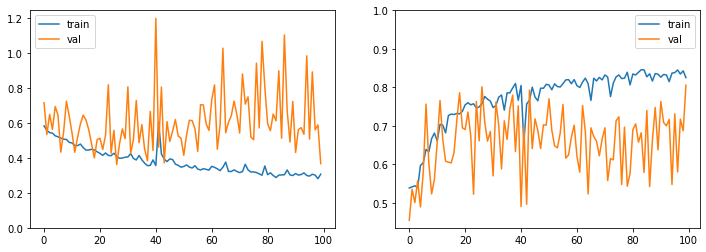

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 14s 3ms/step - loss: 0.5799 - accuracy: 0.6356 - precision: 0.9173 - recall: 0.5991 - f1: 0.7208 - specificity: 0.7804 - negative_predictive_value: 0.3326 - matthews_correlation_coefficient: 0.3070 - equal_error_rate: 0.2953 - val_loss: 0.5884 - val_accuracy: 0.6722 - val_precision: 0.8876 - val_recall: 0.6733 - val_f1: 0.7633 - val_specificity: 0.6595 - val_negative_predictive_value: 0.3458 - val_matthews_correlation_coefficient: 0.2782 - val_equal_error_rate: 0.3158

Epoch 00001: val_equal_error_rate improved from inf to 0.31581, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_04_09-05_13_52.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5609 - accuracy: 0.7011 - precision: 0.9026 - recall: 0.7011 - f1: 0.7870 - specificity: 0.7087 - negative_predictive_value: 0.3840 - matthews_correlation_coefficient: 0.3414 

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5263 - accuracy: 0.7128 - precision: 0.9284 - recall: 0.6951 - f1: 0.7913 - specificity: 0.7854 - negative_predictive_value: 0.4039 - matthews_correlation_coefficient: 0.3980 - equal_error_rate: 0.2511 - val_loss: 0.7390 - val_accuracy: 0.5906 - val_precision: 0.9380 - val_recall: 0.5191 - val_f1: 0.6649 - val_specificity: 0.8560 - val_negative_predictive_value: 0.3145 - val_matthews_correlation_coefficient: 0.3074 - val_equal_error_rate: 0.3084

Epoch 00014: val_equal_error_rate did not improve from 0.30156
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5268 - accuracy: 0.7080 - precision: 0.9251 - recall: 0.6919 - f1: 0.7875 - specificity: 0.7746 - negative_predictive_value: 0.4016 - matthews_correlation_coefficient: 0.3883 - equal_error_rate: 0.2581 - val_loss: 0.5941 - val_accuracy: 0.6834 - val_precision: 0.9174 - val_recall: 0.6606 - val_f1: 0.7654 - val_specificity: 0.7633 - val


Epoch 00026: val_equal_error_rate improved from 0.26588 to 0.26262, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_04_09-05_13_52.h5
Epoch 27/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4962 - accuracy: 0.7386 - precision: 0.9341 - recall: 0.7210 - f1: 0.8113 - specificity: 0.7973 - negative_predictive_value: 0.4319 - matthews_correlation_coefficient: 0.4347 - equal_error_rate: 0.2288 - val_loss: 0.6568 - val_accuracy: 0.6245 - val_precision: 0.9536 - val_recall: 0.5553 - val_f1: 0.6998 - val_specificity: 0.8869 - val_negative_predictive_value: 0.3399 - val_matthews_correlation_coefficient: 0.3600 - val_equal_error_rate: 0.2751

Epoch 00027: val_equal_error_rate did not improve from 0.26262
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4965 - accuracy: 0.7310 - precision: 0.9242 - recall: 0.7257 - f1: 0.8105 - specificity: 0.7663 - negative_predictive_value: 0.4212 - matthews_correlatio

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4843 - accuracy: 0.7523 - precision: 0.9242 - recall: 0.7477 - f1: 0.8226 - specificity: 0.7710 - negative_predictive_value: 0.4566 - matthews_correlation_coefficient: 0.4420 - equal_error_rate: 0.2313 - val_loss: 0.6734 - val_accuracy: 0.5950 - val_precision: 0.9563 - val_recall: 0.5128 - val_f1: 0.6653 - val_specificity: 0.9047 - val_negative_predictive_value: 0.3244 - val_matthews_correlation_coefficient: 0.3420 - val_equal_error_rate: 0.2639

Epoch 00040: val_equal_error_rate did not improve from 0.24921
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4715 - accuracy: 0.7471 - precision: 0.9330 - recall: 0.7425 - f1: 0.8226 - specificity: 0.7897 - negative_predictive_value: 0.4540 - matthews_correlation_coefficient: 0.4513 - equal_error_rate: 0.2228 - val_loss: 0.6013 - val_accuracy: 0.6904 - val_precision: 0.9394 - val_recall: 0.6532 - val_f1: 0.7680 - val_specificity: 0.8255 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4741 - accuracy: 0.7382 - precision: 0.9350 - recall: 0.7164 - f1: 0.8074 - specificity: 0.8046 - negative_predictive_value: 0.4293 - matthews_correlation_coefficient: 0.4345 - equal_error_rate: 0.2303 - val_loss: 0.5512 - val_accuracy: 0.6704 - val_precision: 0.9430 - val_recall: 0.6235 - val_f1: 0.7496 - val_specificity: 0.8497 - val_negative_predictive_value: 0.3657 - val_matthews_correlation_coefficient: 0.3818 - val_equal_error_rate: 0.2324

Epoch 00053: val_equal_error_rate did not improve from 0.22771
Epoch 54/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4642 - accuracy: 0.7544 - precision: 0.9360 - recall: 0.7434 - f1: 0.8241 - specificity: 0.8019 - negative_predictive_value: 0.4540 - matthews_correlation_coefficient: 0.4591 - equal_error_rate: 0.2157 - val_loss: 0.5130 - val_accuracy: 0.6956 - val_precision: 0.9368 - val_recall: 0.6619 - val_f1: 0.7744 - val_specificity: 0.8193 - val


Epoch 00066: val_equal_error_rate did not improve from 0.22771
Epoch 67/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4465 - accuracy: 0.7711 - precision: 0.9383 - recall: 0.7677 - f1: 0.8414 - specificity: 0.7972 - negative_predictive_value: 0.4787 - matthews_correlation_coefficient: 0.4838 - equal_error_rate: 0.2078 - val_loss: 0.6082 - val_accuracy: 0.6409 - val_precision: 0.9527 - val_recall: 0.5723 - val_f1: 0.7117 - val_specificity: 0.8866 - val_negative_predictive_value: 0.3496 - val_matthews_correlation_coefficient: 0.3721 - val_equal_error_rate: 0.2401

Epoch 00067: val_equal_error_rate did not improve from 0.22771
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4411 - accuracy: 0.7753 - precision: 0.9419 - recall: 0.7691 - f1: 0.8438 - specificity: 0.8052 - negative_predictive_value: 0.4854 - matthews_correlation_coefficient: 0.4921 - equal_error_rate: 0.1977 - val_loss: 0.4950 - val_accuracy: 0.7207 - val_precision:


Epoch 00080: val_equal_error_rate did not improve from 0.22771
Epoch 81/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4416 - accuracy: 0.7735 - precision: 0.9406 - recall: 0.7607 - f1: 0.8360 - specificity: 0.8024 - negative_predictive_value: 0.4809 - matthews_correlation_coefficient: 0.4853 - equal_error_rate: 0.1994 - val_loss: 0.6212 - val_accuracy: 0.6262 - val_precision: 0.9534 - val_recall: 0.5550 - val_f1: 0.6993 - val_specificity: 0.8899 - val_negative_predictive_value: 0.3396 - val_matthews_correlation_coefficient: 0.3607 - val_equal_error_rate: 0.2311

Epoch 00081: val_equal_error_rate did not improve from 0.22771
Epoch 82/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4307 - accuracy: 0.7766 - precision: 0.9383 - recall: 0.7730 - f1: 0.8441 - specificity: 0.7963 - negative_predictive_value: 0.4928 - matthews_correlation_coefficient: 0.4931 - equal_error_rate: 0.2024 - val_loss: 0.5477 - val_accuracy: 0.6826 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4191 - accuracy: 0.7855 - precision: 0.9443 - recall: 0.7783 - f1: 0.8508 - specificity: 0.8197 - negative_predictive_value: 0.4939 - matthews_correlation_coefficient: 0.5100 - equal_error_rate: 0.1853 - val_loss: 0.6597 - val_accuracy: 0.6618 - val_precision: 0.9561 - val_recall: 0.5989 - val_f1: 0.7341 - val_specificity: 0.8924 - val_negative_predictive_value: 0.3649 - val_matthews_correlation_coefficient: 0.3967 - val_equal_error_rate: 0.2268

Epoch 00094: val_equal_error_rate did not improve from 0.21875
Epoch 95/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4097 - accuracy: 0.7902 - precision: 0.9461 - recall: 0.7753 - f1: 0.8484 - specificity: 0.8280 - negative_predictive_value: 0.4991 - matthews_correlation_coefficient: 0.5168 - equal_error_rate: 0.1827 - val_loss: 0.6551 - val_accuracy: 0.6635 - val_precision: 0.9359 - val_recall: 0.6178 - val_f1: 0.7420 - val_specificity: 0.8276 - val

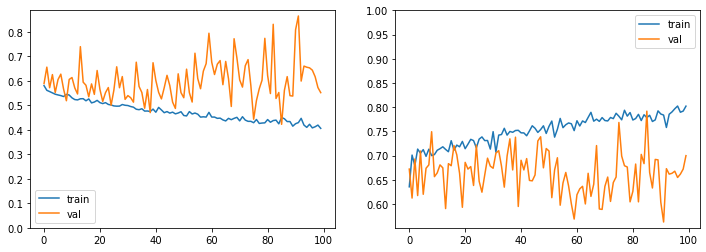

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5931 - accuracy: 0.7837 - precision: 0.9984 - recall: 0.7888 - f1: 0.8686 - specificity: 0.1170 - negative_predictive_value: 0.0060 - matthews_correlation_coefficient: 0.0190 - equal_error_rate: 0.0311 - val_loss: 0.1767 - val_accuracy: 0.9939 - val_precision: 0.9983 - val_recall: 0.9951 - val_f1: 0.9967 - val_specificity: 0.0833 - val_negative_predictive_value: 0.0833 - val_matthews_correlation_coefficient: 0.0825 - val_equal_error_rate: 0.0172

Epoch 00001: val_equal_error_rate improved from inf to 0.01717, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_04_09-05_34_51.h5
Epoch 2/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.4682 - accuracy: 0.8059 - precision: 0.9994 - recall: 0.8039 - f1: 0.8834 - specificity: 0.1986 - negative_predictive_value: 0.0205 - matthews_correlation_coefficient: 0.0441 - equal_er

4610/4610 [==============================] - 11s 2ms/step - loss: 0.1332 - accuracy: 0.9278 - precision: 1.0000 - recall: 0.9289 - f1: 0.9619 - specificity: 0.2766 - negative_predictive_value: 0.0854 - matthews_correlation_coefficient: 0.1305 - equal_error_rate: 0.0062 - val_loss: 0.0250 - val_accuracy: 0.9948 - val_precision: 0.9983 - val_recall: 0.9959 - val_f1: 0.9971 - val_specificity: 0.0833 - val_negative_predictive_value: 0.0417 - val_matthews_correlation_coefficient: 0.0586 - val_equal_error_rate: 0.0058

Epoch 00014: val_equal_error_rate did not improve from 0.00538
Epoch 15/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.1834 - accuracy: 0.9161 - precision: 0.9998 - recall: 0.9138 - f1: 0.9520 - specificity: 0.2447 - negative_predictive_value: 0.0828 - matthews_correlation_coefficient: 0.1200 - equal_error_rate: 0.0070 - val_loss: 0.4568 - val_accuracy: 0.7840 - val_precision: 1.0000 - val_recall: 0.7831 - val_f1: 0.8780 - val_specificity: 0.2500 - val


Epoch 00027: val_equal_error_rate did not improve from 0.00538
Epoch 28/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.1806 - accuracy: 0.9080 - precision: 0.9996 - recall: 0.9099 - f1: 0.9514 - specificity: 0.2340 - negative_predictive_value: 0.0389 - matthews_correlation_coefficient: 0.0823 - equal_error_rate: 0.0066 - val_loss: 0.0398 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9926 - val_f1: 0.9963 - val_specificity: 0.2500 - val_negative_predictive_value: 0.1667 - val_matthews_correlation_coefficient: 0.2006 - val_equal_error_rate: 0.0054

Epoch 00028: val_equal_error_rate did not improve from 0.00538
Epoch 29/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.0891 - accuracy: 0.9731 - precision: 1.0000 - recall: 0.9716 - f1: 0.9853 - specificity: 0.2340 - negative_predictive_value: 0.1045 - matthews_correlation_coefficient: 0.1479 - equal_error_rate: 0.0060 - val_loss: 0.0988 - val_accuracy: 0.9627 - val_precision:


Epoch 00041: val_equal_error_rate did not improve from 0.00538
Epoch 42/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.0408 - accuracy: 0.9822 - precision: 1.0000 - recall: 0.9806 - f1: 0.9901 - specificity: 0.2766 - negative_predictive_value: 0.1681 - matthews_correlation_coefficient: 0.2065 - equal_error_rate: 0.0060 - val_loss: 0.0234 - val_accuracy: 0.9939 - val_precision: 1.0000 - val_recall: 0.9934 - val_f1: 0.9967 - val_specificity: 0.2500 - val_negative_predictive_value: 0.2083 - val_matthews_correlation_coefficient: 0.2253 - val_equal_error_rate: 0.0054

Epoch 00042: val_equal_error_rate did not improve from 0.00538
Epoch 43/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.0328 - accuracy: 0.9857 - precision: 1.0000 - recall: 0.9859 - f1: 0.9928 - specificity: 0.2553 - negative_predictive_value: 0.1379 - matthews_correlation_coefficient: 0.1795 - equal_error_rate: 0.0060 - val_loss: 0.0176 - val_accuracy: 0.9965 - val_precision:

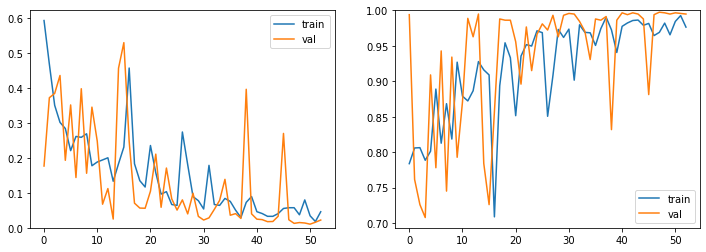

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.6085 - accuracy: 0.6182 - precision: 0.8665 - recall: 0.5456 - f1: 0.6583 - specificity: 0.7767 - negative_predictive_value: 0.4205 - matthews_correlation_coefficient: 0.3034 - equal_error_rate: 0.3327 - val_loss: 0.6232 - val_accuracy: 0.6106 - val_precision: 0.9042 - val_recall: 0.4965 - val_f1: 0.6373 - val_specificity: 0.8709 - val_negative_predictive_value: 0.4180 - val_matthews_correlation_coefficient: 0.3432 - val_equal_error_rate: 0.3000

Epoch 00001: val_equal_error_rate improved from inf to 0.30004, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_04_09-05_44_37.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5898 - accuracy: 0.6330 - precision: 0.8956 - recall: 0.5532 - f1: 0.6761 - specificity: 0.8379 - negative_predictive_value: 0.4337 - matthews_correlation_coefficient: 0.3580 - equal


Epoch 00013: val_equal_error_rate did not improve from 0.29146
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5433 - accuracy: 0.7007 - precision: 0.9126 - recall: 0.6389 - f1: 0.7496 - specificity: 0.8345 - negative_predictive_value: 0.4837 - matthews_correlation_coefficient: 0.4374 - equal_error_rate: 0.2655 - val_loss: 0.5686 - val_accuracy: 0.6860 - val_precision: 0.8670 - val_recall: 0.6469 - val_f1: 0.7384 - val_specificity: 0.7636 - val_negative_predictive_value: 0.4746 - val_matthews_correlation_coefficient: 0.3742 - val_equal_error_rate: 0.3002

Epoch 00014: val_equal_error_rate did not improve from 0.29146
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5464 - accuracy: 0.6950 - precision: 0.8995 - recall: 0.6511 - f1: 0.7475 - specificity: 0.8185 - negative_predictive_value: 0.5020 - matthews_correlation_coefficient: 0.4334 - equal_error_rate: 0.2723 - val_loss: 0.5584 - val_accuracy: 0.6973 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5116 - accuracy: 0.7169 - precision: 0.9191 - recall: 0.6573 - f1: 0.7636 - specificity: 0.8627 - negative_predictive_value: 0.5049 - matthews_correlation_coefficient: 0.4684 - equal_error_rate: 0.2468 - val_loss: 0.5523 - val_accuracy: 0.7069 - val_precision: 0.9022 - val_recall: 0.6528 - val_f1: 0.7550 - val_specificity: 0.8272 - val_negative_predictive_value: 0.4978 - val_matthews_correlation_coefficient: 0.4379 - val_equal_error_rate: 0.2728

Epoch 00027: val_equal_error_rate did not improve from 0.26524
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5101 - accuracy: 0.7243 - precision: 0.9131 - recall: 0.6824 - f1: 0.7776 - specificity: 0.8396 - negative_predictive_value: 0.5272 - matthews_correlation_coefficient: 0.4789 - equal_error_rate: 0.2481 - val_loss: 0.6572 - val_accuracy: 0.6349 - val_precision: 0.9413 - val_recall: 0.5062 - val_f1: 0.6540 - val_specificity: 0.9223 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5040 - accuracy: 0.7154 - precision: 0.9261 - recall: 0.6535 - f1: 0.7614 - specificity: 0.8663 - negative_predictive_value: 0.5048 - matthews_correlation_coefficient: 0.4720 - equal_error_rate: 0.2393 - val_loss: 0.4906 - val_accuracy: 0.7277 - val_precision: 0.8537 - val_recall: 0.7406 - val_f1: 0.7915 - val_specificity: 0.6922 - val_negative_predictive_value: 0.5250 - val_matthews_correlation_coefficient: 0.4046 - val_equal_error_rate: 0.2662

Epoch 00040: val_equal_error_rate did not improve from 0.24913
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5057 - accuracy: 0.7189 - precision: 0.9079 - recall: 0.6726 - f1: 0.7670 - specificity: 0.8367 - negative_predictive_value: 0.5212 - matthews_correlation_coefficient: 0.4667 - equal_error_rate: 0.2463 - val_loss: 0.6012 - val_accuracy: 0.6678 - val_precision: 0.9382 - val_recall: 0.5631 - val_f1: 0.7002 - val_specificity: 0.9069 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4819 - accuracy: 0.7317 - precision: 0.9215 - recall: 0.6855 - f1: 0.7837 - specificity: 0.8573 - negative_predictive_value: 0.5283 - matthews_correlation_coefficient: 0.4936 - equal_error_rate: 0.2289 - val_loss: 0.4956 - val_accuracy: 0.7346 - val_precision: 0.8937 - val_recall: 0.7048 - val_f1: 0.7861 - val_specificity: 0.7945 - val_negative_predictive_value: 0.5288 - val_matthews_correlation_coefficient: 0.4590 - val_equal_error_rate: 0.2585

Epoch 00053: val_equal_error_rate did not improve from 0.23888
Epoch 54/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4760 - accuracy: 0.7440 - precision: 0.9189 - recall: 0.7040 - f1: 0.7926 - specificity: 0.8550 - negative_predictive_value: 0.5505 - matthews_correlation_coefficient: 0.5113 - equal_error_rate: 0.2268 - val_loss: 0.5582 - val_accuracy: 0.6982 - val_precision: 0.9308 - val_recall: 0.6158 - val_f1: 0.7386 - val_specificity: 0.8864 - val


Epoch 00066: val_equal_error_rate improved from 0.23888 to 0.23707, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_04_09-05_44_37.h5
Epoch 67/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4669 - accuracy: 0.7486 - precision: 0.9226 - recall: 0.7022 - f1: 0.7949 - specificity: 0.8536 - negative_predictive_value: 0.5433 - matthews_correlation_coefficient: 0.5084 - equal_error_rate: 0.2166 - val_loss: 0.5446 - val_accuracy: 0.7016 - val_precision: 0.8895 - val_recall: 0.6618 - val_f1: 0.7562 - val_specificity: 0.7997 - val_negative_predictive_value: 0.4946 - val_matthews_correlation_coefficient: 0.4206 - val_equal_error_rate: 0.2614

Epoch 00067: val_equal_error_rate did not improve from 0.23707
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4620 - accuracy: 0.7538 - precision: 0.9203 - recall: 0.7125 - f1: 0.8015 - specificity: 0.8474 - negative_predictive_value: 0.5469 - matthews_correlation_coeff

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4577 - accuracy: 0.7531 - precision: 0.9251 - recall: 0.7148 - f1: 0.8043 - specificity: 0.8588 - negative_predictive_value: 0.5553 - matthews_correlation_coefficient: 0.5244 - equal_error_rate: 0.2083 - val_loss: 0.5827 - val_accuracy: 0.6843 - val_precision: 0.9306 - val_recall: 0.5939 - val_f1: 0.7218 - val_specificity: 0.8898 - val_negative_predictive_value: 0.4763 - val_matthews_correlation_coefficient: 0.4430 - val_equal_error_rate: 0.2393

Epoch 00080: val_equal_error_rate did not improve from 0.23544
Epoch 81/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4802 - accuracy: 0.7332 - precision: 0.9246 - recall: 0.6846 - f1: 0.7806 - specificity: 0.8489 - negative_predictive_value: 0.5329 - matthews_correlation_coefficient: 0.4934 - equal_error_rate: 0.2245 - val_loss: 0.5177 - val_accuracy: 0.7242 - val_precision: 0.9109 - val_recall: 0.6757 - val_f1: 0.7734 - val_specificity: 0.8349 - val


Epoch 00093: val_equal_error_rate improved from 0.23544 to 0.23311, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_04_09-05_44_37.h5
Epoch 94/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4383 - accuracy: 0.7718 - precision: 0.9336 - recall: 0.7358 - f1: 0.8208 - specificity: 0.8721 - negative_predictive_value: 0.5750 - matthews_correlation_coefficient: 0.5552 - equal_error_rate: 0.1938 - val_loss: 0.5076 - val_accuracy: 0.7433 - val_precision: 0.9133 - val_recall: 0.7015 - val_f1: 0.7911 - val_specificity: 0.8344 - val_negative_predictive_value: 0.5381 - val_matthews_correlation_coefficient: 0.4915 - val_equal_error_rate: 0.2366

Epoch 00094: val_equal_error_rate did not improve from 0.23311
Epoch 95/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4382 - accuracy: 0.7666 - precision: 0.9289 - recall: 0.7307 - f1: 0.8157 - specificity: 0.8630 - negative_predictive_value: 0.5738 - matthews_correlation_coeff

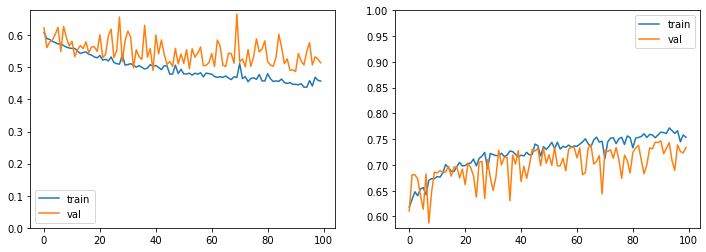

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 16s 3ms/step - loss: 0.6131 - accuracy: 0.5987 - precision: 0.9261 - recall: 0.5698 - f1: 0.6947 - specificity: 0.7358 - negative_predictive_value: 0.2348 - matthews_correlation_coefficient: 0.2202 - equal_error_rate: 0.3366 - val_loss: 0.7080 - val_accuracy: 0.4926 - val_precision: 0.9693 - val_recall: 0.4164 - val_f1: 0.5803 - val_specificity: 0.9316 - val_negative_predictive_value: 0.2104 - val_matthews_correlation_coefficient: 0.2472 - val_equal_error_rate: 0.2998

Epoch 00001: val_equal_error_rate improved from inf to 0.29981, saving model to ../models/autoencoders_requirements/hat_cap_2020_04_09-06_04_53.h5
Epoch 2/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.5726 - accuracy: 0.6007 - precision: 0.9411 - recall: 0.5671 - f1: 0.6984 - specificity: 0.7720 - negative_predictive_value: 0.2423 - matthews_correlation_coefficient: 0.2480 - equal_error_rate:


Epoch 00013: val_equal_error_rate did not improve from 0.19833
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4852 - accuracy: 0.7013 - precision: 0.9588 - recall: 0.6838 - f1: 0.7945 - specificity: 0.8130 - negative_predictive_value: 0.3085 - matthews_correlation_coefficient: 0.3637 - equal_error_rate: 0.2312 - val_loss: 0.4529 - val_accuracy: 0.7641 - val_precision: 0.9463 - val_recall: 0.7688 - val_f1: 0.8472 - val_specificity: 0.7411 - val_negative_predictive_value: 0.3450 - val_matthews_correlation_coefficient: 0.3821 - val_equal_error_rate: 0.2336

Epoch 00014: val_equal_error_rate did not improve from 0.19833
Epoch 15/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4794 - accuracy: 0.7137 - precision: 0.9491 - recall: 0.7049 - f1: 0.8069 - specificity: 0.7826 - negative_predictive_value: 0.3150 - matthews_correlation_coefficient: 0.3569 - equal_error_rate: 0.2389 - val_loss: 0.4418 - val_accuracy: 0.7485 - val_precision:

4610/4610 [==============================] - 13s 3ms/step - loss: 0.4868 - accuracy: 0.7132 - precision: 0.9568 - recall: 0.7005 - f1: 0.8017 - specificity: 0.7844 - negative_predictive_value: 0.3298 - matthews_correlation_coefficient: 0.3697 - equal_error_rate: 0.2282 - val_loss: 0.3436 - val_accuracy: 0.8317 - val_precision: 0.9215 - val_recall: 0.8789 - val_f1: 0.8992 - val_specificity: 0.5536 - val_negative_predictive_value: 0.4190 - val_matthews_correlation_coefficient: 0.3805 - val_equal_error_rate: 0.2130

Epoch 00027: val_equal_error_rate did not improve from 0.19388
Epoch 28/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4383 - accuracy: 0.7438 - precision: 0.9649 - recall: 0.7301 - f1: 0.8273 - specificity: 0.8392 - negative_predictive_value: 0.3624 - matthews_correlation_coefficient: 0.4281 - equal_error_rate: 0.2002 - val_loss: 0.3398 - val_accuracy: 0.8265 - val_precision: 0.9307 - val_recall: 0.8601 - val_f1: 0.8933 - val_specificity: 0.6091 - val

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4056 - accuracy: 0.7668 - precision: 0.9693 - recall: 0.7515 - f1: 0.8444 - specificity: 0.8632 - negative_predictive_value: 0.3815 - matthews_correlation_coefficient: 0.4617 - equal_error_rate: 0.1831 - val_loss: 0.3546 - val_accuracy: 0.8257 - val_precision: 0.9428 - val_recall: 0.8467 - val_f1: 0.8915 - val_specificity: 0.6859 - val_negative_predictive_value: 0.4255 - val_matthews_correlation_coefficient: 0.4396 - val_equal_error_rate: 0.1957

Epoch 00040: val_equal_error_rate did not improve from 0.18313
Epoch 41/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4106 - accuracy: 0.7646 - precision: 0.9656 - recall: 0.7479 - f1: 0.8394 - specificity: 0.8468 - negative_predictive_value: 0.3796 - matthews_correlation_coefficient: 0.4506 - equal_error_rate: 0.1828 - val_loss: 0.3569 - val_accuracy: 0.8309 - val_precision: 0.9404 - val_recall: 0.8567 - val_f1: 0.8960 - val_specificity: 0.6784 - val


Epoch 00053: val_equal_error_rate did not improve from 0.17947
Epoch 54/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4925 - accuracy: 0.7063 - precision: 0.9578 - recall: 0.6954 - f1: 0.7894 - specificity: 0.8024 - negative_predictive_value: 0.3477 - matthews_correlation_coefficient: 0.3838 - equal_error_rate: 0.2104 - val_loss: 0.3454 - val_accuracy: 0.8404 - val_precision: 0.9336 - val_recall: 0.8745 - val_f1: 0.9024 - val_specificity: 0.6325 - val_negative_predictive_value: 0.4564 - val_matthews_correlation_coefficient: 0.4411 - val_equal_error_rate: 0.1998

Epoch 00054: val_equal_error_rate did not improve from 0.17947
Epoch 55/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4025 - accuracy: 0.7777 - precision: 0.9637 - recall: 0.7727 - f1: 0.8550 - specificity: 0.8362 - negative_predictive_value: 0.4053 - matthews_correlation_coefficient: 0.4695 - equal_error_rate: 0.1806 - val_loss: 0.3275 - val_accuracy: 0.8317 - val_precision:


Epoch 00067: val_equal_error_rate did not improve from 0.17947
Epoch 68/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3714 - accuracy: 0.7887 - precision: 0.9708 - recall: 0.7691 - f1: 0.8534 - specificity: 0.8615 - negative_predictive_value: 0.4128 - matthews_correlation_coefficient: 0.4880 - equal_error_rate: 0.1701 - val_loss: 0.3182 - val_accuracy: 0.8465 - val_precision: 0.9431 - val_recall: 0.8743 - val_f1: 0.9069 - val_specificity: 0.6867 - val_negative_predictive_value: 0.4728 - val_matthews_correlation_coefficient: 0.4804 - val_equal_error_rate: 0.1930

Epoch 00068: val_equal_error_rate did not improve from 0.17947
Epoch 69/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.3592 - accuracy: 0.7926 - precision: 0.9726 - recall: 0.7802 - f1: 0.8642 - specificity: 0.8478 - negative_predictive_value: 0.4016 - matthews_correlation_coefficient: 0.4839 - equal_error_rate: 0.1573 - val_loss: 0.2957 - val_accuracy: 0.8708 - val_precision:


Epoch 00081: val_equal_error_rate did not improve from 0.17947
Epoch 82/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3506 - accuracy: 0.8104 - precision: 0.9702 - recall: 0.7994 - f1: 0.8743 - specificity: 0.8682 - negative_predictive_value: 0.4441 - matthews_correlation_coefficient: 0.5223 - equal_error_rate: 0.1609 - val_loss: 0.5714 - val_accuracy: 0.6574 - val_precision: 0.9856 - val_recall: 0.6050 - val_f1: 0.7491 - val_specificity: 0.9482 - val_negative_predictive_value: 0.2859 - val_matthews_correlation_coefficient: 0.3840 - val_equal_error_rate: 0.1700

Epoch 00082: val_equal_error_rate improved from 0.17947 to 0.17001, saving model to ../models/autoencoders_requirements/hat_cap_2020_04_09-06_04_53.h5
Epoch 83/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3772 - accuracy: 0.7809 - precision: 0.9684 - recall: 0.7718 - f1: 0.8513 - specificity: 0.8381 - negative_predictive_value: 0.4105 - matthews_correlation_coefficient: 0.47

4610/4610 [==============================] - 12s 3ms/step - loss: 0.3642 - accuracy: 0.7948 - precision: 0.9731 - recall: 0.7795 - f1: 0.8624 - specificity: 0.8701 - negative_predictive_value: 0.4218 - matthews_correlation_coefficient: 0.5025 - equal_error_rate: 0.1555 - val_loss: 0.3492 - val_accuracy: 0.8023 - val_precision: 0.9441 - val_recall: 0.8169 - val_f1: 0.8750 - val_specificity: 0.7209 - val_negative_predictive_value: 0.3901 - val_matthews_correlation_coefficient: 0.4208 - val_equal_error_rate: 0.1789

Epoch 00095: val_equal_error_rate did not improve from 0.16261
Epoch 96/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3489 - accuracy: 0.8078 - precision: 0.9771 - recall: 0.7972 - f1: 0.8750 - specificity: 0.8644 - negative_predictive_value: 0.4371 - matthews_correlation_coefficient: 0.5205 - equal_error_rate: 0.1418 - val_loss: 0.3045 - val_accuracy: 0.8569 - val_precision: 0.9408 - val_recall: 0.8898 - val_f1: 0.9139 - val_specificity: 0.6626 - val

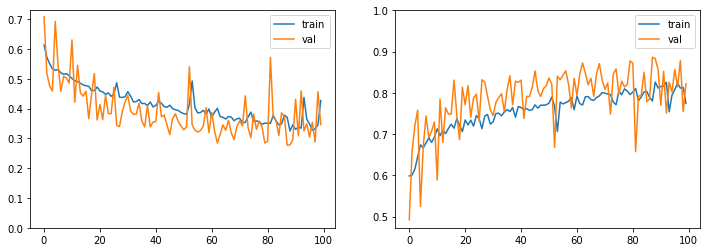

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4504 - accuracy: 0.7289 - precision: 0.9937 - recall: 0.7138 - f1: 0.8247 - specificity: 0.8914 - negative_predictive_value: 0.1888 - matthews_correlation_coefficient: 0.3302 - equal_error_rate: 0.1127 - val_loss: 0.4122 - val_accuracy: 0.8135 - val_precision: 0.9890 - val_recall: 0.8107 - val_f1: 0.8908 - val_specificity: 0.8719 - val_negative_predictive_value: 0.2332 - val_matthews_correlation_coefficient: 0.3870 - val_equal_error_rate: 0.1347

Epoch 00001: val_equal_error_rate improved from inf to 0.13470, saving model to ../models/autoencoders_requirements/veil_over_face_2020_04_09-06_26_14.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.3261 - accuracy: 0.8486 - precision: 0.9937 - recall: 0.8466 - f1: 0.9133 - specificity: 0.9235 - negative_predictive_value: 0.3016 - matthews_correlation_coefficient: 0.4671 - equal_erro


Epoch 00013: val_equal_error_rate did not improve from 0.09061
Epoch 14/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2269 - accuracy: 0.9239 - precision: 0.9922 - recall: 0.9257 - f1: 0.9575 - specificity: 0.8649 - negative_predictive_value: 0.4451 - matthews_correlation_coefficient: 0.5776 - equal_error_rate: 0.0557 - val_loss: 0.3542 - val_accuracy: 0.8838 - val_precision: 0.9899 - val_recall: 0.8835 - val_f1: 0.9334 - val_specificity: 0.8719 - val_negative_predictive_value: 0.3400 - val_matthews_correlation_coefficient: 0.4948 - val_equal_error_rate: 0.1160

Epoch 00014: val_equal_error_rate did not improve from 0.09061
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2268 - accuracy: 0.9150 - precision: 0.9936 - recall: 0.9168 - f1: 0.9532 - specificity: 0.9128 - negative_predictive_value: 0.4458 - matthews_correlation_coefficient: 0.5951 - equal_error_rate: 0.0488 - val_loss: 0.2090 - val_accuracy: 0.9324 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.2048 - accuracy: 0.9284 - precision: 0.9904 - recall: 0.9280 - f1: 0.9577 - specificity: 0.8935 - negative_predictive_value: 0.4737 - matthews_correlation_coefficient: 0.6050 - equal_error_rate: 0.0461 - val_loss: 0.2036 - val_accuracy: 0.9462 - val_precision: 0.9906 - val_recall: 0.9499 - val_f1: 0.9696 - val_specificity: 0.8677 - val_negative_predictive_value: 0.5605 - val_matthews_correlation_coefficient: 0.6656 - val_equal_error_rate: 0.0870

Epoch 00027: val_equal_error_rate improved from 0.08924 to 0.08703, saving model to ../models/autoencoders_requirements/veil_over_face_2020_04_09-06_26_14.h5
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.2139 - accuracy: 0.9065 - precision: 0.9926 - recall: 0.9047 - f1: 0.9458 - specificity: 0.9087 - negative_predictive_value: 0.4079 - matthews_correlation_coefficient: 0.5619 - equal_error_rate: 0.0530 - val_loss: 0.2850 - val_accuracy: 0.908


Epoch 00040: val_equal_error_rate did not improve from 0.07641
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1674 - accuracy: 0.9488 - precision: 0.9941 - recall: 0.9522 - f1: 0.9724 - specificity: 0.9049 - negative_predictive_value: 0.5926 - matthews_correlation_coefficient: 0.6989 - equal_error_rate: 0.0431 - val_loss: 0.2148 - val_accuracy: 0.9297 - val_precision: 0.9915 - val_recall: 0.9308 - val_f1: 0.9599 - val_specificity: 0.8812 - val_negative_predictive_value: 0.4697 - val_matthews_correlation_coefficient: 0.6057 - val_equal_error_rate: 0.0932

Epoch 00041: val_equal_error_rate did not improve from 0.07641
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1676 - accuracy: 0.9471 - precision: 0.9945 - recall: 0.9498 - f1: 0.9713 - specificity: 0.9266 - negative_predictive_value: 0.6029 - matthews_correlation_coefficient: 0.7125 - equal_error_rate: 0.0359 - val_loss: 0.2032 - val_accuracy: 0.9367 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.1926 - accuracy: 0.9098 - precision: 0.9952 - recall: 0.9082 - f1: 0.9478 - specificity: 0.9357 - negative_predictive_value: 0.5000 - matthews_correlation_coefficient: 0.6290 - equal_error_rate: 0.0501 - val_loss: 0.2414 - val_accuracy: 0.9263 - val_precision: 0.9914 - val_recall: 0.9279 - val_f1: 0.9585 - val_specificity: 0.8812 - val_negative_predictive_value: 0.4543 - val_matthews_correlation_coefficient: 0.5954 - val_equal_error_rate: 0.0932

Epoch 00054: val_equal_error_rate did not improve from 0.07589
Epoch 55/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.1525 - accuracy: 0.9540 - precision: 0.9940 - recall: 0.9575 - f1: 0.9750 - specificity: 0.8937 - negative_predictive_value: 0.6483 - matthews_correlation_coefficient: 0.7296 - equal_error_rate: 0.0377 - val_loss: 0.1532 - val_accuracy: 0.9488 - val_precision: 0.9907 - val_recall: 0.9519 - val_f1: 0.9707 - val_specificity: 0.8719 - val


Epoch 00067: val_equal_error_rate improved from 0.07322 to 0.07317, saving model to ../models/autoencoders_requirements/veil_over_face_2020_04_09-06_26_14.h5
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1515 - accuracy: 0.9497 - precision: 0.9955 - recall: 0.9516 - f1: 0.9722 - specificity: 0.9445 - negative_predictive_value: 0.6511 - matthews_correlation_coefficient: 0.7458 - equal_error_rate: 0.0297 - val_loss: 0.3277 - val_accuracy: 0.9029 - val_precision: 0.9932 - val_recall: 0.9007 - val_f1: 0.9443 - val_specificity: 0.9043 - val_negative_predictive_value: 0.3913 - val_matthews_correlation_coefficient: 0.5504 - val_equal_error_rate: 0.0941

Epoch 00068: val_equal_error_rate did not improve from 0.07317
Epoch 69/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1627 - accuracy: 0.9436 - precision: 0.9948 - recall: 0.9422 - f1: 0.9672 - specificity: 0.9031 - negative_predictive_value: 0.5629 - matthews_correlation_coefficien

4610/4610 [==============================] - 11s 2ms/step - loss: 0.4400 - accuracy: 0.8536 - precision: 0.9933 - recall: 0.8508 - f1: 0.9113 - specificity: 0.8798 - negative_predictive_value: 0.3547 - matthews_correlation_coefficient: 0.4834 - equal_error_rate: 0.0700 - val_loss: 0.3633 - val_accuracy: 0.8647 - val_precision: 0.9939 - val_recall: 0.8568 - val_f1: 0.9197 - val_specificity: 0.9210 - val_negative_predictive_value: 0.3090 - val_matthews_correlation_coefficient: 0.4802 - val_equal_error_rate: 0.0923

Epoch 00081: val_equal_error_rate did not improve from 0.07053
Epoch 82/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1897 - accuracy: 0.9330 - precision: 0.9943 - recall: 0.9356 - f1: 0.9637 - specificity: 0.9137 - negative_predictive_value: 0.5106 - matthews_correlation_coefficient: 0.6432 - equal_error_rate: 0.0468 - val_loss: 0.1622 - val_accuracy: 0.9532 - val_precision: 0.9890 - val_recall: 0.9589 - val_f1: 0.9735 - val_specificity: 0.8418 - val


Epoch 00094: val_equal_error_rate did not improve from 0.07053
Epoch 95/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1466 - accuracy: 0.9523 - precision: 0.9955 - recall: 0.9544 - f1: 0.9742 - specificity: 0.9012 - negative_predictive_value: 0.5920 - matthews_correlation_coefficient: 0.6996 - equal_error_rate: 0.0291 - val_loss: 0.2509 - val_accuracy: 0.9150 - val_precision: 0.9913 - val_recall: 0.9156 - val_f1: 0.9517 - val_specificity: 0.8812 - val_negative_predictive_value: 0.4213 - val_matthews_correlation_coefficient: 0.5676 - val_equal_error_rate: 0.0910

Epoch 00095: val_equal_error_rate did not improve from 0.07053
Epoch 96/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.1346 - accuracy: 0.9529 - precision: 0.9946 - recall: 0.9524 - f1: 0.9726 - specificity: 0.9068 - negative_predictive_value: 0.5830 - matthews_correlation_coefficient: 0.6963 - equal_error_rate: 0.0274 - val_loss: 0.2067 - val_accuracy: 0.9193 - val_precision:

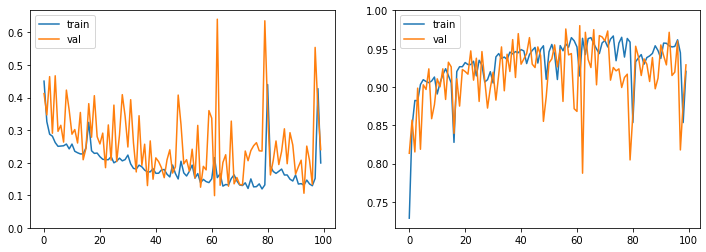

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 16s 4ms/step - loss: 0.6164 - accuracy: 0.6484 - precision: 0.8771 - recall: 0.6138 - f1: 0.7137 - specificity: 0.7410 - negative_predictive_value: 0.4166 - matthews_correlation_coefficient: 0.3186 - equal_error_rate: 0.3249 - val_loss: 0.6170 - val_accuracy: 0.6219 - val_precision: 0.8747 - val_recall: 0.5625 - val_f1: 0.6828 - val_specificity: 0.7807 - val_negative_predictive_value: 0.3931 - val_matthews_correlation_coefficient: 0.3030 - val_equal_error_rate: 0.3317

Epoch 00001: val_equal_error_rate improved from inf to 0.33174, saving model to ../models/autoencoders_requirements/mouth_open_2020_04_09-06_46_41.h5
Epoch 2/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5845 - accuracy: 0.6492 - precision: 0.8947 - recall: 0.5885 - f1: 0.7071 - specificity: 0.8114 - negative_predictive_value: 0.4172 - matthews_correlation_coefficient: 0.3522 - equal_error_ra

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5419 - accuracy: 0.7069 - precision: 0.8909 - recall: 0.6880 - f1: 0.7740 - specificity: 0.7668 - negative_predictive_value: 0.4726 - matthews_correlation_coefficient: 0.4059 - equal_error_rate: 0.2689 - val_loss: 0.5900 - val_accuracy: 0.6522 - val_precision: 0.8872 - val_recall: 0.6046 - val_f1: 0.7182 - val_specificity: 0.7904 - val_negative_predictive_value: 0.4189 - val_matthews_correlation_coefficient: 0.3476 - val_equal_error_rate: 0.3036

Epoch 00014: val_equal_error_rate did not improve from 0.29448
Epoch 15/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5405 - accuracy: 0.7026 - precision: 0.9059 - recall: 0.6628 - f1: 0.7615 - specificity: 0.8033 - negative_predictive_value: 0.4687 - matthews_correlation_coefficient: 0.4170 - equal_error_rate: 0.2697 - val_loss: 0.7314 - val_accuracy: 0.5880 - val_precision: 0.8986 - val_recall: 0.4940 - val_f1: 0.6355 - val_specificity: 0.8504 - val

4610/4610 [==============================] - 13s 3ms/step - loss: 0.5297 - accuracy: 0.7141 - precision: 0.8979 - recall: 0.6883 - f1: 0.7739 - specificity: 0.7777 - negative_predictive_value: 0.4739 - matthews_correlation_coefficient: 0.4153 - equal_error_rate: 0.2552 - val_loss: 0.6805 - val_accuracy: 0.6141 - val_precision: 0.9037 - val_recall: 0.5298 - val_f1: 0.6666 - val_specificity: 0.8472 - val_negative_predictive_value: 0.3935 - val_matthews_correlation_coefficient: 0.3344 - val_equal_error_rate: 0.3059

Epoch 00027: val_equal_error_rate did not improve from 0.28990
Epoch 28/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5263 - accuracy: 0.7249 - precision: 0.8986 - recall: 0.7059 - f1: 0.7881 - specificity: 0.7747 - negative_predictive_value: 0.4937 - matthews_correlation_coefficient: 0.4339 - equal_error_rate: 0.2571 - val_loss: 0.5889 - val_accuracy: 0.6635 - val_precision: 0.8883 - val_recall: 0.6188 - val_f1: 0.7282 - val_specificity: 0.7873 - val


Epoch 00040: val_equal_error_rate did not improve from 0.28964
Epoch 41/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5180 - accuracy: 0.7139 - precision: 0.9046 - recall: 0.6848 - f1: 0.7765 - specificity: 0.8015 - negative_predictive_value: 0.4812 - matthews_correlation_coefficient: 0.4324 - equal_error_rate: 0.2478 - val_loss: 0.5382 - val_accuracy: 0.7138 - val_precision: 0.8662 - val_recall: 0.7215 - val_f1: 0.7863 - val_specificity: 0.6947 - val_negative_predictive_value: 0.4755 - val_matthews_correlation_coefficient: 0.3769 - val_equal_error_rate: 0.2888

Epoch 00041: val_equal_error_rate improved from 0.28964 to 0.28881, saving model to ../models/autoencoders_requirements/mouth_open_2020_04_09-06_46_41.h5
Epoch 42/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5162 - accuracy: 0.7269 - precision: 0.9003 - recall: 0.7100 - f1: 0.7909 - specificity: 0.7764 - negative_predictive_value: 0.4905 - matthews_correlation_coefficient: 0

4610/4610 [==============================] - 12s 3ms/step - loss: 0.5115 - accuracy: 0.7176 - precision: 0.9051 - recall: 0.6876 - f1: 0.7779 - specificity: 0.7831 - negative_predictive_value: 0.4754 - matthews_correlation_coefficient: 0.4226 - equal_error_rate: 0.2440 - val_loss: 0.5423 - val_accuracy: 0.7025 - val_precision: 0.8716 - val_recall: 0.6957 - val_f1: 0.7725 - val_specificity: 0.7198 - val_negative_predictive_value: 0.4636 - val_matthews_correlation_coefficient: 0.3730 - val_equal_error_rate: 0.2874

Epoch 00054: val_equal_error_rate did not improve from 0.28081
Epoch 55/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5031 - accuracy: 0.7213 - precision: 0.9086 - recall: 0.6926 - f1: 0.7843 - specificity: 0.8075 - negative_predictive_value: 0.4893 - matthews_correlation_coefficient: 0.4456 - equal_error_rate: 0.2440 - val_loss: 0.5921 - val_accuracy: 0.6782 - val_precision: 0.8856 - val_recall: 0.6426 - val_f1: 0.7431 - val_specificity: 0.7761 - val


Epoch 00067: val_equal_error_rate did not improve from 0.27773
Epoch 68/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4958 - accuracy: 0.7308 - precision: 0.9037 - recall: 0.7049 - f1: 0.7891 - specificity: 0.8008 - negative_predictive_value: 0.5022 - matthews_correlation_coefficient: 0.4525 - equal_error_rate: 0.2449 - val_loss: 0.5779 - val_accuracy: 0.6782 - val_precision: 0.9040 - val_recall: 0.6296 - val_f1: 0.7405 - val_specificity: 0.8187 - val_negative_predictive_value: 0.4457 - val_matthews_correlation_coefficient: 0.3957 - val_equal_error_rate: 0.2802

Epoch 00068: val_equal_error_rate did not improve from 0.27773
Epoch 69/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4939 - accuracy: 0.7282 - precision: 0.9134 - recall: 0.7016 - f1: 0.7908 - specificity: 0.8102 - negative_predictive_value: 0.4958 - matthews_correlation_coefficient: 0.4570 - equal_error_rate: 0.2385 - val_loss: 0.5714 - val_accuracy: 0.6774 - val_precision:

4610/4610 [==============================] - 12s 3ms/step - loss: 0.4932 - accuracy: 0.7254 - precision: 0.9095 - recall: 0.6956 - f1: 0.7843 - specificity: 0.8102 - negative_predictive_value: 0.4972 - matthews_correlation_coefficient: 0.4527 - equal_error_rate: 0.2441 - val_loss: 0.6178 - val_accuracy: 0.6496 - val_precision: 0.9146 - val_recall: 0.5796 - val_f1: 0.7077 - val_specificity: 0.8562 - val_negative_predictive_value: 0.4252 - val_matthews_correlation_coefficient: 0.3845 - val_equal_error_rate: 0.2813

Epoch 00081: val_equal_error_rate did not improve from 0.27128
Epoch 82/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4860 - accuracy: 0.7254 - precision: 0.9218 - recall: 0.6872 - f1: 0.7847 - specificity: 0.8383 - negative_predictive_value: 0.4940 - matthews_correlation_coefficient: 0.4668 - equal_error_rate: 0.2322 - val_loss: 0.4980 - val_accuracy: 0.7138 - val_precision: 0.8669 - val_recall: 0.7231 - val_f1: 0.7880 - val_specificity: 0.6961 - val


Epoch 00094: val_equal_error_rate did not improve from 0.26659
Epoch 95/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4719 - accuracy: 0.7382 - precision: 0.9029 - recall: 0.7010 - f1: 0.7874 - specificity: 0.8132 - negative_predictive_value: 0.5059 - matthews_correlation_coefficient: 0.4576 - equal_error_rate: 0.2413 - val_loss: 0.5750 - val_accuracy: 0.6956 - val_precision: 0.8857 - val_recall: 0.6703 - val_f1: 0.7614 - val_specificity: 0.7645 - val_negative_predictive_value: 0.4603 - val_matthews_correlation_coefficient: 0.3877 - val_equal_error_rate: 0.2818

Epoch 00095: val_equal_error_rate did not improve from 0.26659
Epoch 96/100
4610/4610 [==============================] - 13s 3ms/step - loss: 0.4892 - accuracy: 0.7371 - precision: 0.9090 - recall: 0.7121 - f1: 0.7952 - specificity: 0.7966 - negative_predictive_value: 0.5072 - matthews_correlation_coefficient: 0.4595 - equal_error_rate: 0.2402 - val_loss: 0.5384 - val_accuracy: 0.7077 - val_precision:

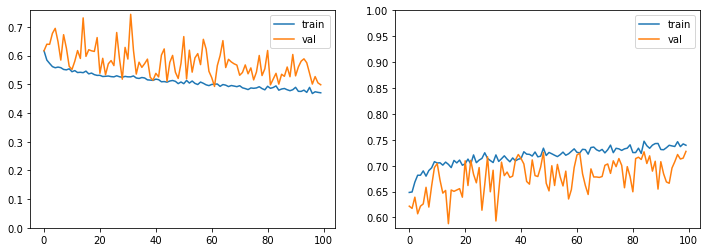

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4842 - accuracy: 0.7091 - precision: 0.9944 - recall: 0.7122 - f1: 0.8123 - specificity: 0.5443 - negative_predictive_value: 0.0410 - matthews_correlation_coefficient: 0.1024 - equal_error_rate: 0.0860 - val_loss: 0.4532 - val_accuracy: 0.8257 - val_precision: 0.9989 - val_recall: 0.8283 - val_f1: 0.9046 - val_specificity: 0.7500 - val_negative_predictive_value: 0.0725 - val_matthews_correlation_coefficient: 0.2014 - val_equal_error_rate: 0.0378

Epoch 00001: val_equal_error_rate improved from inf to 0.03782, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_04_09-07_07_53.h5
Epoch 2/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.3826 - accuracy: 0.8195 - precision: 0.9983 - recall: 0.8184 - f1: 0.8980 - specificity: 0.5053 - negative_predictive_value: 0.0528 - matthews_correlation_coefficient: 0.

4610/4610 [==============================] - 10s 2ms/step - loss: 0.2746 - accuracy: 0.8575 - precision: 0.9990 - recall: 0.8574 - f1: 0.9224 - specificity: 0.6206 - negative_predictive_value: 0.0711 - matthews_correlation_coefficient: 0.1865 - equal_error_rate: 0.0304 - val_loss: 0.3254 - val_accuracy: 0.8291 - val_precision: 1.0000 - val_recall: 0.8293 - val_f1: 0.9058 - val_specificity: 0.8333 - val_negative_predictive_value: 0.0735 - val_matthews_correlation_coefficient: 0.2188 - val_equal_error_rate: 0.0252

Epoch 00013: val_equal_error_rate improved from 0.02607 to 0.02524, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_04_09-07_07_53.h5
Epoch 14/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2737 - accuracy: 0.8501 - precision: 0.9992 - recall: 0.8499 - f1: 0.9181 - specificity: 0.6277 - negative_predictive_value: 0.0709 - matthews_correlation_coefficient: 0.1875 - equal_error_rate: 0.0313 - val_loss: 0.4224 - va


Epoch 00025: val_equal_error_rate did not improve from 0.01553
Epoch 26/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2494 - accuracy: 0.8599 - precision: 0.9993 - recall: 0.8595 - f1: 0.9236 - specificity: 0.6082 - negative_predictive_value: 0.0699 - matthews_correlation_coefficient: 0.1823 - equal_error_rate: 0.0258 - val_loss: 0.4381 - val_accuracy: 0.7892 - val_precision: 1.0000 - val_recall: 0.7898 - val_f1: 0.8813 - val_specificity: 0.8333 - val_negative_predictive_value: 0.0603 - val_matthews_correlation_coefficient: 0.1942 - val_equal_error_rate: 0.0247

Epoch 00026: val_equal_error_rate did not improve from 0.01553
Epoch 27/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2490 - accuracy: 0.8395 - precision: 1.0000 - recall: 0.8407 - f1: 0.9124 - specificity: 0.7234 - negative_predictive_value: 0.0721 - matthews_correlation_coefficient: 0.2010 - equal_error_rate: 0.0238 - val_loss: 0.2647 - val_accuracy: 0.8647 - val_precision:


Epoch 00039: val_equal_error_rate did not improve from 0.01515
Epoch 40/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2851 - accuracy: 0.8304 - precision: 0.9995 - recall: 0.8302 - f1: 0.9063 - specificity: 0.6702 - negative_predictive_value: 0.0665 - matthews_correlation_coefficient: 0.1863 - equal_error_rate: 0.0263 - val_loss: 0.2887 - val_accuracy: 0.8430 - val_precision: 1.0000 - val_recall: 0.8429 - val_f1: 0.9139 - val_specificity: 0.8333 - val_negative_predictive_value: 0.0810 - val_matthews_correlation_coefficient: 0.2309 - val_equal_error_rate: 0.0160

Epoch 00040: val_equal_error_rate did not improve from 0.01515
Epoch 41/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2263 - accuracy: 0.8675 - precision: 1.0000 - recall: 0.8666 - f1: 0.9281 - specificity: 0.7234 - negative_predictive_value: 0.0879 - matthews_correlation_coefficient: 0.2285 - equal_error_rate: 0.0234 - val_loss: 0.3442 - val_accuracy: 0.8526 - val_precision:

4610/4610 [==============================] - 10s 2ms/step - loss: 0.1908 - accuracy: 0.8892 - precision: 0.9998 - recall: 0.8864 - f1: 0.9393 - specificity: 0.7163 - negative_predictive_value: 0.1032 - matthews_correlation_coefficient: 0.2494 - equal_error_rate: 0.0167 - val_loss: 0.3474 - val_accuracy: 0.8526 - val_precision: 0.9973 - val_recall: 0.8554 - val_f1: 0.9201 - val_specificity: 0.6667 - val_negative_predictive_value: 0.0709 - val_matthews_correlation_coefficient: 0.1874 - val_equal_error_rate: 0.0222

Epoch 00053: val_equal_error_rate did not improve from 0.01304
Epoch 54/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2515 - accuracy: 0.8310 - precision: 0.9995 - recall: 0.8288 - f1: 0.9049 - specificity: 0.6596 - negative_predictive_value: 0.0679 - matthews_correlation_coefficient: 0.1837 - equal_error_rate: 0.0227 - val_loss: 0.2941 - val_accuracy: 0.8413 - val_precision: 1.0000 - val_recall: 0.8411 - val_f1: 0.9132 - val_specificity: 0.8333 - val_

4610/4610 [==============================] - 10s 2ms/step - loss: 0.2167 - accuracy: 0.8662 - precision: 1.0000 - recall: 0.8652 - f1: 0.9274 - specificity: 0.7447 - negative_predictive_value: 0.0812 - matthews_correlation_coefficient: 0.2229 - equal_error_rate: 0.0214 - val_loss: 0.2376 - val_accuracy: 0.8916 - val_precision: 0.9974 - val_recall: 0.8941 - val_f1: 0.9423 - val_specificity: 0.6667 - val_negative_predictive_value: 0.0967 - val_matthews_correlation_coefficient: 0.2242 - val_equal_error_rate: 0.0309

Epoch 00066: val_equal_error_rate did not improve from 0.01304
Epoch 67/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2142 - accuracy: 0.8742 - precision: 0.9997 - recall: 0.8715 - f1: 0.9306 - specificity: 0.6738 - negative_predictive_value: 0.0879 - matthews_correlation_coefficient: 0.2193 - equal_error_rate: 0.0208 - val_loss: 0.1516 - val_accuracy: 0.9133 - val_precision: 0.9956 - val_recall: 0.9168 - val_f1: 0.9544 - val_specificity: 0.5000 - val


Epoch 00079: val_equal_error_rate did not improve from 0.01304
Epoch 80/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1753 - accuracy: 0.8933 - precision: 1.0000 - recall: 0.8919 - f1: 0.9427 - specificity: 0.6383 - negative_predictive_value: 0.1052 - matthews_correlation_coefficient: 0.2373 - equal_error_rate: 0.0159 - val_loss: 0.2341 - val_accuracy: 0.8916 - val_precision: 0.9974 - val_recall: 0.8941 - val_f1: 0.9424 - val_specificity: 0.6667 - val_negative_predictive_value: 0.0909 - val_matthews_correlation_coefficient: 0.2185 - val_equal_error_rate: 0.0210

Epoch 00080: val_equal_error_rate did not improve from 0.01304
Epoch 81/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2035 - accuracy: 0.8742 - precision: 1.0000 - recall: 0.8731 - f1: 0.9318 - specificity: 0.6170 - negative_predictive_value: 0.0836 - matthews_correlation_coefficient: 0.2073 - equal_error_rate: 0.0193 - val_loss: 0.2724 - val_accuracy: 0.8621 - val_precision: 1

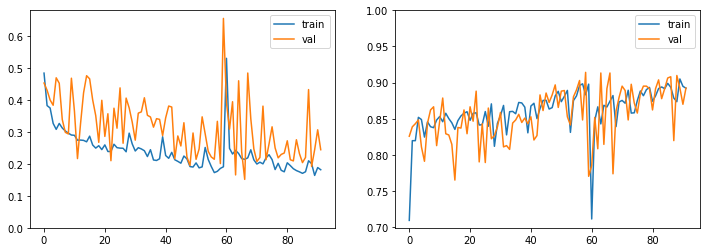

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [6]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_04_09-00_13_47.h5'
 '../models/autoencoders_requirements/looking_away_2020_04_09-00_34_29.h5'
 '../models/autoencoders_requirements/ink_marked_creased_2020_04_09-00_55_45.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_04_09-01_05_40.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5'
 '../models/autoencoders_requirements/washed_out_2020_04_09-01_48_25.h5'
 '../models/autoencoders_requirements/pixelation_2020_04_09-02_00_17.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_04_09-02_20_15.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_04_09-02_40_49.h5'
 '../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_04_09-03_23_09.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_09-03_35_11.h5'
 '../models/autoencoders_requirements/red_eyes_2020_04_09-03_57_03.h5'
 

In [7]:
file_models = np.array([
    '../models/autoencoders_requirements/blurred_2020_04_09-00_13_47.h5',
    '../models/autoencoders_requirements/looking_away_2020_04_09-00_34_29.h5',
    '../models/autoencoders_requirements/ink_marked_creased_2020_04_09-00_55_45.h5',
    '../models/autoencoders_requirements/unnatural_skin_tone_2020_04_09-01_05_40.h5',
    '../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5',
    '../models/autoencoders_requirements/washed_out_2020_04_09-01_48_25.h5',
    '../models/autoencoders_requirements/pixelation_2020_04_09-02_00_17.h5',
    '../models/autoencoders_requirements/hair_across_eyes_2020_04_09-02_20_15.h5',
    '../models/autoencoders_requirements/eyes_closed_2020_04_09-02_40_49.h5',
    '../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5',
    '../models/autoencoders_requirements/roll_pitch_yaw_2020_04_09-03_23_09.h5',
    '../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_09-03_35_11.h5',
    '../models/autoencoders_requirements/red_eyes_2020_04_09-03_57_03.h5',
    '../models/autoencoders_requirements/shadows_behind_head_2020_04_09-04_17_49.h5',
    '../models/autoencoders_requirements/shadows_across_face_2020_04_09-04_39_28.h5',
    '../models/autoencoders_requirements/dark_tinted_lenses_2020_04_09-04_53_40.h5',
    '../models/autoencoders_requirements/flash_reflection_on_lenses_2020_04_09-05_13_52.h5',
    '../models/autoencoders_requirements/frames_too_heavy_2020_04_09-05_34_51.h5',
    '../models/autoencoders_requirements/frame_covering_eyes_2020_04_09-05_44_37.h5',
    '../models/autoencoders_requirements/hat_cap_2020_04_09-06_04_53.h5',
    '../models/autoencoders_requirements/veil_over_face_2020_04_09-06_26_14.h5',
    '../models/autoencoders_requirements/mouth_open_2020_04_09-06_46_41.h5',
    '../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_04_09-07_07_53.h5'
])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_04_09-00_13_47.h5'
 '../models/autoencoders_requirements/looking_away_2020_04_09-00_34_29.h5'
 '../models/autoencoders_requirements/ink_marked_creased_2020_04_09-00_55_45.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_04_09-01_05_40.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_04_09-01_27_28.h5'
 '../models/autoencoders_requirements/washed_out_2020_04_09-01_48_25.h5'
 '../models/autoencoders_requirements/pixelation_2020_04_09-02_00_17.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_04_09-02_20_15.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_04_09-02_40_49.h5'
 '../models/autoencoders_requirements/varied_background_2020_04_09-03_01_50.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_04_09-03_23_09.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_09-03_35_11.h5'
 '../models/autoencoders_requirements/red_eyes_2020_04_09-03_57_03.h5'
 

In [8]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [10]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [11]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

In [12]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.99987495]], dtype=float32),
 array([[0.73250043]], dtype=float32),
 array([[0.77413875]], dtype=float32),
 array([[0.9698146]], dtype=float32),
 array([[0.9152913]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.88945305]], dtype=float32),
 array([[0.7393494]], dtype=float32),
 array([[0.44422424]], dtype=float32),
 array([[0.51074415]], dtype=float32),
 array([[0.8377602]], dtype=float32),
 array([[0.98424983]], dtype=float32),
 array([[0.81138843]], dtype=float32),
 array([[0.9988342]], dtype=float32),
 array([[0.9674984]], dtype=float32),
 array([[0.9782275]], dtype=float32),
 array([[0.24334776]], dtype=float32),
 array([[0.9855232]], dtype=float32),
 array([[0.8467277]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[0.99831486]], dtype=float32),
 array([[0.50321156]], dtype=float32),
 array([[1.]], dtype=float32)]